## Implement Quasiparticle Hamiltonian on a Digital Quantum Computer

In [1]:
import qiskit
import numpy as np
from qiskit.quantum_info import SparsePauliOp

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from typing import Dict


Load matrix elements for $^{6}He$

In [2]:
data_onebody=np.load('data/matrix_elements_h_eff_2body/one_body_nn_p.npz')
keys=data_onebody['keys']
values=data_onebody['values']
n_qubits=3

t_onebody={}

for a,key in enumerate(keys):
    i,j=key
    t_onebody[(i,j)]=values[a]

# print(t_onebody)
# t_onebody.pop((0,1))
# t_onebody.pop((0,2))
# t_onebody.pop((1,2))

print(t_onebody)

{(0, 0): -18.4321, (0, 1): 1.0430999999999995, (0, 2): -3.763858685577873, (1, 0): 1.0430999999999995, (1, 1): -18.4321, (1, 2): 3.763858685577873, (2, 0): -3.763858685577873, (2, 1): 3.763858685577873, (2, 2): -15.1203}


#### Build-up $H_Q$

In [3]:
def get_hamiltonian(t_onebody:Dict, n_sites:int):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    XX_tuples=[]
    YY_tuples=[]
    Z_tuples=[]
    I_tuples=[]
    for (i,j),t_val in t_onebody.items():
    
        if i==j:
            Z_tuples.append(("Z", [i], -0.5*t_val))
            I_tuples.append(('I',[i],0.5*t_val)) 
        else:
            XX_tuples.append( ("XX", [i, j], 0.25*t_val) )
            YY_tuples.append(("YY", [i, j], 0.25*t_val) )
            
    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*XX_tuples, *YY_tuples,*Z_tuples,*I_tuples], num_qubits=n_sites)
    return hamiltonian.simplify()



Get the manybody basis

In [4]:
import numpy as np
from qiskit.quantum_info import Statevector

n_sites=n_qubits
basis_states = [Statevector.from_label(np.binary_repr(i, width=n_sites)) for i in range(2**n_sites)]

bitstring_to_index = {np.binary_repr(i, width=n_sites): i for i in range(2**n_sites)}
index_to_bitstring = {i: np.binary_repr(i, width=n_sites) for i in range(2**n_sites)}

In [5]:
print(index_to_bitstring)

{0: '000', 1: '001', 2: '010', 3: '011', 4: '100', 5: '101', 6: '110', 7: '111'}


In [6]:
hamiltonian_q=get_hamiltonian(t_onebody=t_onebody,n_sites=n_qubits)




#### Qiskit has the sick problem that the occupation value 1 becomes 0 (they define $S_z$ in the opposite way). Therefore, to select the Hamiltonian fixed in the one quasiparticle many-body basis we need to consider the conversion to the full bitstrig basis 

bitstring_index= 63- $2^{sp \; index}$

In [7]:
from scipy.sparse import csr_matrix



for i in range(1,n_qubits+1):
    for j in range(1,n_qubits+1):
        
        print(f'i={(i-1)},j={(j-1)} ->{csr_matrix(hamiltonian_q.to_matrix())[2**(i-1),2**(j-1)]} \n')
        
### We got exactly the same Hamiltonian!

i=0,j=0 ->(-18.4321+0j) 

i=0,j=1 ->(1.0430999999999995+0j) 

i=0,j=2 ->(-3.763858685577873+0j) 

i=1,j=0 ->(1.0430999999999995+0j) 

i=1,j=1 ->(-18.4321+0j) 

i=1,j=2 ->(3.763858685577873+0j) 

i=2,j=0 ->(-3.763858685577873+0j) 

i=2,j=1 ->(3.763858685577873+0j) 

i=2,j=2 ->(-15.1203+0j) 



Build up the total number of particles term

In [8]:
Z_tuples=[("Z", [i], -0.5) for i in range(n_qubits)]
I_tuples=[('I',[i],0.5) for i in range(n_qubits)]
n_operator = SparsePauliOp.from_sparse_list([*Z_tuples,*I_tuples], num_qubits=n_qubits)

print(n_operator.to_matrix())

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 2.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 2.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 2.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 3.+0.j]]


#### Build-up the driver Hamiltonian

In [9]:
coupling_term=-18.4321
Z_tuples=[("Z", [0], -0.5*coupling_term)]
I_tuples=[('I',[0],0.5*coupling_term)]

        
# We create the Hamiltonian as a SparsePauliOp, via the method
# `from_sparse_list`, and multiply by the interaction term.
hamiltonian_driver = SparsePauliOp.from_sparse_list([*Z_tuples,*I_tuples], num_qubits=n_qubits)


print(hamiltonian_driver)

SparsePauliOp(['IIZ', 'III'],
              coeffs=[ 9.21605+0.j, -9.21605+0.j])


In [10]:
from scipy.sparse import csr_matrix



for i in range(1,n_qubits+1):
    for j in range(1,n_qubits+1):
        
        print(f'i={(i-1)},j={(j-1)} ->{csr_matrix(hamiltonian_driver.to_matrix())[2**(i-1),2**(j-1)]} \n')
        

i=0,j=0 ->(-18.4321+0j) 

i=0,j=1 ->0j 

i=0,j=2 ->0j 

i=1,j=0 ->0j 

i=1,j=1 ->0j 

i=1,j=2 ->0j 

i=2,j=0 ->0j 

i=2,j=1 ->0j 

i=2,j=2 ->0j 



#### Let's perform the SUZUKI-TROTTER

In [1]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter,QDrift
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import transpile
from qiskit.quantum_info import Statevector
import json

Trotter-Time evolution without noise

In [12]:

#final_state=Statevector(circuit_opt)
time_steps=100
tf=10
time=np.linspace(0,tf,time_steps)
dt=tf/time_steps
print(dt)
#b=0.8
#h=1-(1+b)*(time/tf)+b*(time/tf)**2
driver=1-time/tf
circuit_time_evolution=QuantumCircuit(hamiltonian_q.num_qubits)
circuit_time_evolution.x([0]) # initial state

energies_qiskit=np.zeros((time_steps))


for n,t in enumerate(time):
    hamiltonian_t=(driver[n])*hamiltonian_driver+(1-driver[n])*hamiltonian_q
    exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
    #exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=QDrift(reps=5))
    circuit_time_evolution.append(exp_H_t,range(hamiltonian_q.num_qubits))
    single_particle_vector=np.zeros(2**n_qubits,dtype=np.complex128)
    psi_for_fidelity=np.zeros(n_qubits,dtype=np.complex128)
    for a in range(n_qubits):
        a_mb=2**(a)
        final_state=Statevector(circuit_time_evolution).data
        single_particle_vector[a_mb]=final_state[a_mb]
        psi_for_fidelity[a]=final_state[a_mb]
    energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t).real

transpiled_circuit_time_evolution=transpile(circuit_time_evolution.decompose(), optimization_level=3,basis_gates=['cx','s','h','rz','x'])
final_state=Statevector(circuit_time_evolution)

0.1


In [ ]:
transpiled_circuit_time_evolution.draw()
from qiskit.visualization import circuit_drawer
circuit_drawer(transpiled_circuit_time_evolution, output='mpl', filename='qiskit_circuit.pdf', fold=-1)

In [ ]:
qc=transpiled_circuit_time_evolution

# Function to convert Qiskit circuit to the desired JSON format
def circuit_to_custom_json(circuit):
    data = []
    for inst, qargs, cargs in circuit.data:
        name = inst.name
        qubits = [circuit.qubits.index(q) for q in qargs]  # fixed
        # Get the parameter if it exists, otherwise use 1
        param = inst.params[0] if inst.params else 1
        data.append([name, qubits, param])
    return data

# Convert and save
circuit_json = circuit_to_custom_json(qc)
with open("data/qa_circuit_2.json", "w") as f:
    json.dump(circuit_json, f, indent=4)

print("Circuit saved to 'circuit.json'")

In [14]:
data=np.load('data/quantum_annealing_pure_qa_6he.npz')

spectrum=data['spectrum']

energy=data['energy']

psi=data['psi_exact']

fidelity=data['fidelity']

binding_energy=-20


In [15]:
fidelity_trotter_clean=psi_for_fidelity.conjugate().dot(psi)*np.conjugate(psi_for_fidelity.conjugate().dot(psi))
print(fidelity_trotter_clean,fidelity)
print(energy[-1])

[0.99227506+1.54130666e-17j] (0.9994033234395915+0j)
-23.04538270499555


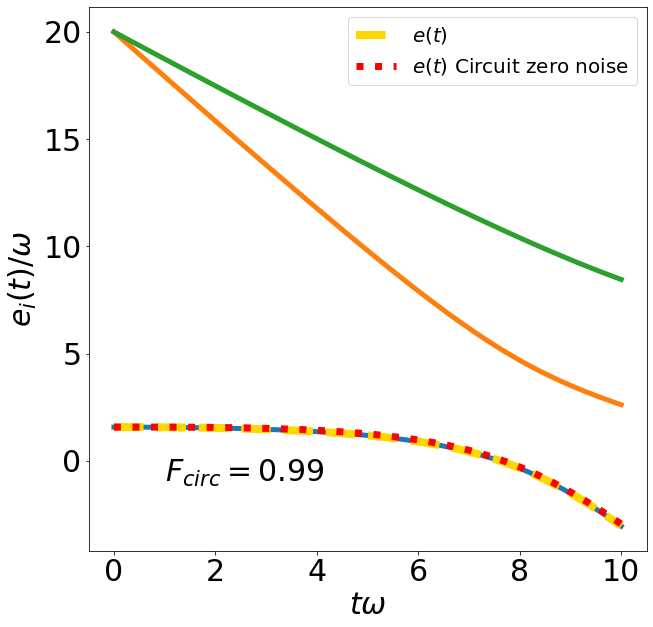

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(3):
    plt.plot(time,spectrum[:,i]-binding_energy,linewidth=5)
plt.plot(time,energy-binding_energy,color='gold',linestyle='--',linewidth=8,label=r'$e(t)$')
plt.plot(time,energies_qiskit-binding_energy,color='red',linestyle=':',linewidth=7,label=r'$e(t)$ Circuit zero noise')
plt.tick_params(labelsize=30)
plt.xlabel(r'$t\omega$',fontsize=30)
plt.text(x=1,y=-1.,s=r'$F_{circ}=0.99$',fontsize=30)
plt.ylabel(r'$e_i(t)/\omega$',fontsize=30)
plt.legend(fontsize=20)
plt.show()

In [17]:

print(
    f"""
Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: {transpiled_circuit_time_evolution.depth()}
             Gate count: {len(transpiled_circuit_time_evolution)}
    Nonlocal gate count: {transpiled_circuit_time_evolution.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in transpiled_circuit_time_evolution.count_ops().items()])}

"""
)



# And finall
%matplotlib inline
#initial_state.draw("text")


Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: 2381
             Gate count: 3569
    Nonlocal gate count: 1188
         Gate breakdown: RZ: 1191, H: 1190, CX: 1188




#### Analysis of the Annealing with tunable noise

Imports

In [18]:
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import Fake5QV1  # or another IBM backend
from qiskit import transpile
from qiskit.quantum_info import DensityMatrix,state_fidelity
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError

transpiled_circuit_time_evolution.save_density_matrix()

Only Depolarization CX

In [19]:

cx_error_rates=10**np.linspace(-5,-1,40)
infidelity=[]
energies_vs_noise=[]
conservation_check=[]

for r,cx_error_rate in enumerate(cx_error_rates):

    # Create a noise model
    noise_model = NoiseModel()

    # Add gate errors
    cx_depol = depolarizing_error(cx_error_rate, 2)
    #rz_depol = depolarizing_error(1e-5, 1)
    #x_depol = depolarizing_error(1e-4, 1)
    #h_depol = depolarizing_error(1e-4, 1)
    # Add depolarizing errors
    noise_model.add_all_qubit_quantum_error(cx_depol, 'cx')
    #noise_model.add_all_qubit_quantum_error(rz_depol, 'rz')
    #noise_model.add_all_qubit_quantum_error(x_depol, 'x')
    #noise_model.add_all_qubit_quantum_error(x_depol, 'x')


    # Add thermal relaxation errors
    # thermal_1q = thermal_relaxation_error(t1, t2, gate_time_1q)
    # thermal_2q = thermal_relaxation_error(t1, t2, gate_time_2q)

    # for gate in ['sx', 'rz', 'x']:
    #     noise_model.add_all_qubit_quantum_error(thermal_1q, gate)
    #trnoise_model.add_all_qubit_quantum_error(thermal_2q, 'cz')



    sim = AerSimulator(noise_model=noise_model)
    
    # Transpile and run
    tqc = transpile(transpiled_circuit_time_evolution, sim,optimization_level=3)
    result = sim.run(tqc).result()


    dm = result.data(0)['density_matrix']
    final_state_with_noise=DensityMatrix(dm)
    eng_tau=final_state_with_noise.expectation_value(hamiltonian_q)
    n_conservation=final_state_with_noise.expectation_value(n_operator)-1
    f_tau=state_fidelity(final_state_with_noise,final_state)
    print(1-f_tau)
    print(eng_tau,'\n')
    energies_vs_noise.append(eng_tau)
    infidelity.append(1-f_tau)
    conservation_check.append(n_conservation)

energies_vs_noise=np.asarray(energies_vs_noise)
infidelity=np.asarray(infidelity)
conservation_check=np.asarray(conservation_check)

0.009282323619666077
(-23.0182268493361-4.423671017940061e-15j) 

0.01173799838615086
(-23.022603982366757+4.690073006315409e-15j) 

0.01483764207052174
(-23.02814138320379+1.9800214910796006e-15j) 

0.018746714628513184
(-23.035144656028603-1.2094108376005252e-15j) 

0.023671143377802295
(-23.04399869947271-1.2034350844852574e-15j) 

0.029865988737581728
(-23.05518753504892+1.6487956062449494e-16j) 

0.03764520692851092
(-23.069318618523877+2.2429867588274363e-15j) 

0.04739213529437658
(-23.087152328815655+2.575261204133292e-15j) 

0.05956988735000679
(-23.109637199029457+3.59948022526766e-15j) 

0.07473014569538816
(-23.137951085768364-5.871598982624866e-15j) 

0.0935177807212062
(-23.17354768042223+1.8213196709580324e-15j) 

0.11666720258445373
(-23.218206229449557-2.4482607173469676e-15j) 

0.1449843261281487
(-23.274079551241343-4.951168566192992e-15j) 

0.17930561016869095
(-23.343730644191808-5.4450923178781936e-15j) 

0.22042331202237508
(-23.430140307509376+1.0242776510855071

Adding the one qubit error depolarization

In [18]:
cx_error_rates=10**np.linspace(-5,-1,40)
infidelity_1qerror=[]
energies_vs_noise_1qerror=[]
conservation_check_1qerror=[]

for r,cx_error_rate in enumerate(cx_error_rates):

    # Create a noise model
    noise_model = NoiseModel()

    # Add gate errors
    cx_depol = depolarizing_error(cx_error_rate, 2)
    rz_depol = depolarizing_error(2.024e-4, 1)
    #x_depol = depolarizing_error(1e-4, 1)
    h_depol = depolarizing_error(2.024e-4, 1)
    # Add depolarizing errors
    noise_model.add_all_qubit_quantum_error(cx_depol, 'cx')
    noise_model.add_all_qubit_quantum_error(rz_depol, 'rz')
    #noise_model.add_all_qubit_quantum_error(x_depol, 'x')
    noise_model.add_all_qubit_quantum_error(h_depol, 'h')


    # Add thermal relaxation errors
    # thermal_1q = thermal_relaxation_error(t1, t2, gate_time_1q)
    # thermal_2q = thermal_relaxation_error(t1, t2, gate_time_2q)

    # for gate in ['sx', 'rz', 'x']:
    #     noise_model.add_all_qubit_quantum_error(thermal_1q, gate)
    #trnoise_model.add_all_qubit_quantum_error(thermal_2q, 'cz')



    sim = AerSimulator(noise_model=noise_model)
    
    # Transpile and run
    tqc = transpile(transpiled_circuit_time_evolution, sim,optimization_level=3)
    result = sim.run(tqc).result()


    dm = result.data(0)['density_matrix']
    final_state_with_noise=DensityMatrix(dm)
    eng_tau=final_state_with_noise.expectation_value(hamiltonian_q)
    n_conservation=final_state_with_noise.expectation_value(n_operator)-1
    f_tau=state_fidelity(final_state_with_noise,final_state)
    print(1-f_tau)
    print(eng_tau,'\n')
    energies_vs_noise_1qerror.append(eng_tau)
    infidelity_1qerror.append(1-f_tau)
    conservation_check_1qerror.append(n_conservation)

energies_vs_noise_1qerror=np.asarray(energies_vs_noise_1qerror)
infidelity_1qerror=np.asarray(infidelity_1qerror)
conservation_check_1qerror=np.asarray(conservation_check_1qerror)

0.238434269305845
(-23.360338987693503-3.478525299872799e-15j) 

0.24022628624161046
(-23.364469359863563-1.005773743767233e-15j) 

0.2424882876679233
(-23.369693103788876+6.379163675886012e-16j) 

0.24534106120442933
(-23.376297317519043+1.490745289137834e-15j) 

0.24893495478938765
(-23.38464306611722+2.043825471397586e-15j) 

0.2534562184117283
(-23.39518356762365-2.7245540694526107e-15j) 

0.25913415662338946
(-23.40848630643126-4.846075912441217e-15j) 

0.2662488241233111
(-23.425259566055672-1.3915918778420472e-15j) 

0.27513867919721546
(-23.446383672347125-2.3417165662210474e-15j) 

0.28620710305587893
(-23.47294678438843-7.358723908904996e-16j) 

0.29992592337323687
(-23.506284189869504-1.1508055908565078e-15j) 

0.3168329745812214
(-23.548018467836023-2.808905082681793e-15j) 

0.33751924925780497
(-23.600095153674946-3.4258744090532898e-15j) 

0.3625994250782516
(-23.664804066454803+1.7321534520025133e-15j) 

0.3926578379958028
(-23.744769461748646+2.142267851478824e-15j) 

0

Adding decoherence

In [19]:
cx_error_rates=10**np.linspace(-5,-1,40)
infidelity_dec=[]
energies_vs_noise_dec=[]
conservation_check_dec=[]

for r,cx_error_rate in enumerate(cx_error_rates):

    # Create a noise model
    noise_model = NoiseModel()
    t1 = 220.96 * 1e3  # 225.54 us to ns
    t2 = 132.35 * 1e3  # 183.22 us to ns
    gate_time=68
    # Add gate errors
    cx_depol = depolarizing_error(cx_error_rate, 2)
    rz_depol = depolarizing_error(2.024e-4, 1)
    #x_depol = depolarizing_error(1e-4, 1)
    h_depol = depolarizing_error(2.024e-4, 1)
    # Add depolarizing errors



    # Add thermal relaxation errors
    thermal_1q = thermal_relaxation_error(t1, t2, gate_time)
    # thermal_2q = thermal_relaxation_error(t1, t2, gate_time_2q)

        
    #cx_depol.compose(thermal_1q)
    rz_error=rz_depol.compose(thermal_1q)
    h_error=h_depol.compose(thermal_1q)


    noise_model.add_all_qubit_quantum_error(cx_depol, 'cx')
    noise_model.add_all_qubit_quantum_error(rz_error, 'rz')
    #noise_model.add_all_qubit_quantum_error(x_depol, 'x')
    noise_model.add_all_qubit_quantum_error(h_error, 'h')


    sim = AerSimulator(noise_model=noise_model)
    
    # Transpile and run
    tqc = transpile(transpiled_circuit_time_evolution, sim,optimization_level=3)
    result = sim.run(tqc).result()


    dm = result.data(0)['density_matrix']
    final_state_with_noise=DensityMatrix(dm)
    eng_tau=final_state_with_noise.expectation_value(hamiltonian_q)
    n_conservation=final_state_with_noise.expectation_value(n_operator)-1
    f_tau=state_fidelity(final_state_with_noise,final_state)
    print(1-f_tau)
    print(eng_tau,'\n')
    energies_vs_noise_dec.append(eng_tau)
    infidelity_dec.append(1-f_tau)
    conservation_check_dec.append(n_conservation)

energies_vs_noise_dec=np.asarray(energies_vs_noise_dec)
infidelity_dec=np.asarray(infidelity_dec)
conservation_check_dec=np.asarray(conservation_check_dec)

0.5123772719692411
(-21.781986113557014+9.049370098530926e-16j) 

0.5133703866223183
(-21.787436346242544+1.0651798795852074e-15j) 

0.5146240241737217
(-21.794327558275036-2.500548796140188e-15j) 

0.5162051778764759
(-21.80303706861281-1.7016404788028954e-15j) 

0.5181972592848566
(-21.81403878925447-1.3886837831706598e-15j) 



0.5207036349677284
(-21.82792661601263+1.3109135989457813e-15j) 

0.5238516253287875
(-21.84544266403805-2.5772228775021707e-16j) 

0.5277968240417464
(-21.867510828430866-4.967415897265389e-16j) 

0.5327274239074814
(-21.895275818167722+1.2408837804178958e-15j) 

0.538867958494446
(-21.930147139552236+4.896638075391082e-16j) 

0.5464814477594244
(-21.973846287141164-1.3099491682860964e-15j) 

0.5558683287904058
(-22.02845332117282-3.211948404316133e-16j) 

0.5673597374805375
(-22.096445647101845+1.803078047610117e-15j) 

0.5813017232335567
(-22.180716617560627+1.7611310335267536e-15j) 

0.5980260098090778
(-22.28455397961638+9.092520967797765e-17j) 

0.6178024205065517
(-22.411547851869972+7.926142898020499e-16j) 

0.6407689752081714
(-22.565385386432805-2.0991260210763626e-16j) 

0.6668394374285689
(-22.749477314290182+9.901264355449962e-16j) 

0.6955966831411251
(-22.966357497906632-9.18787232700876e-16j) 

0.7261951537847338
(-23.216815486969026+2.6515754220217658e-17j) 

0.7573154

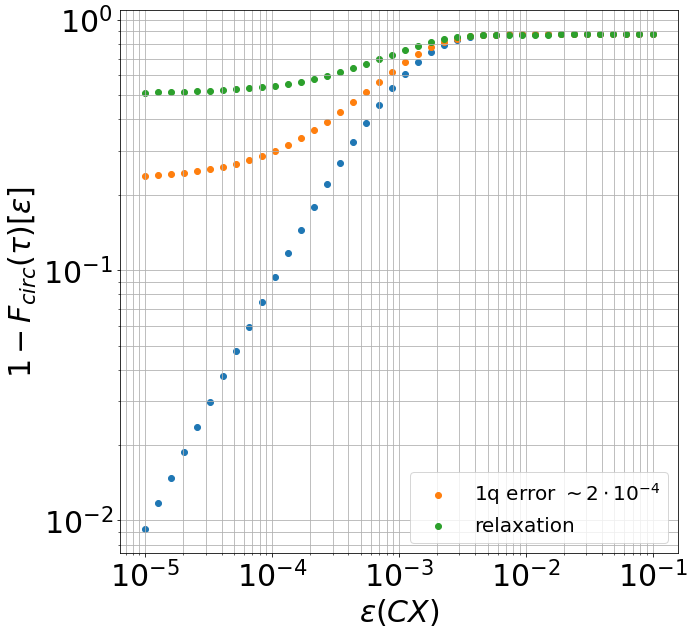

In [20]:
#plt.plot(cx_error_rates,infidelity[-1]-infidelity)
plt.figure(figsize=(10,10))
plt.scatter(cx_error_rates,infidelity)
plt.scatter(cx_error_rates,infidelity_1qerror,label='1q error $\sim 2 \cdot 10^{-4}$')
plt.scatter(cx_error_rates,infidelity_dec,label='relaxation')
#plt.axvline(x=2*10**-3,color='red',linestyle='--',label='best CX gate error')
plt.legend(fontsize=20)
plt.loglog()
plt.grid(which='minor')
plt.grid(which='major')
plt.tick_params(labelsize=30)
plt.xlabel(r'$\epsilon(CX)$',fontsize=30)
plt.ylabel(r'$1-F_{circ}(\tau)[\epsilon]$',fontsize=30)

plt.show()

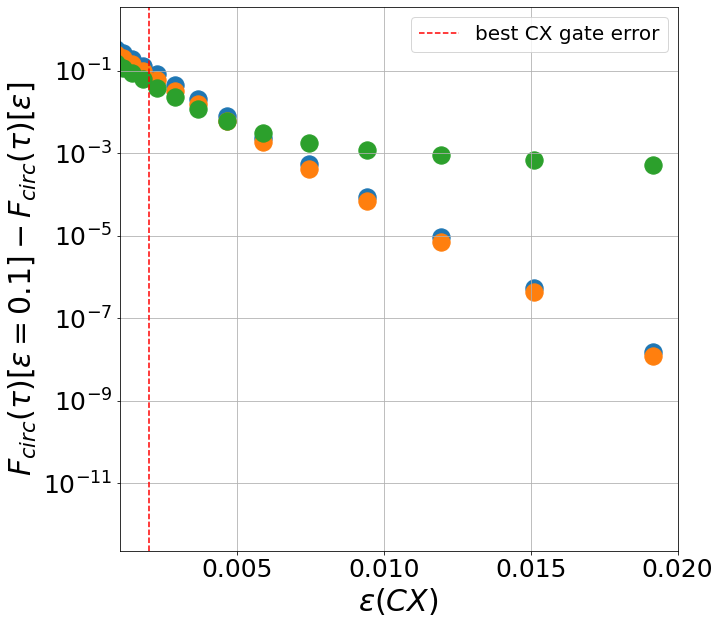

In [21]:
plt.figure(figsize=(10,10))
plt.scatter(cx_error_rates,infidelity[-1]-infidelity+10**-12,s=300)
plt.scatter(cx_error_rates,infidelity_1qerror[-1]-infidelity_1qerror+10**-12,s=300)
plt.scatter(cx_error_rates,infidelity_dec[-1]-infidelity_dec+10**-12,s=300)
plt.axvline(x=2*10**-3,color='red',linestyle='--',label='best CX gate error')
plt.legend(fontsize=20)
plt.semilogy()
plt.grid(which='minor')
plt.grid(which='major')
plt.tick_params(labelsize=25)
plt.xlabel(r'$\epsilon(CX)$',fontsize=30)
plt.xlim([1*10**-3,0.02])
plt.ylabel(r'$F_{circ}(\tau)[\epsilon=0.1]-F_{circ}(\tau)[\epsilon]$',fontsize=30)

plt.show()

Combination of the two plots

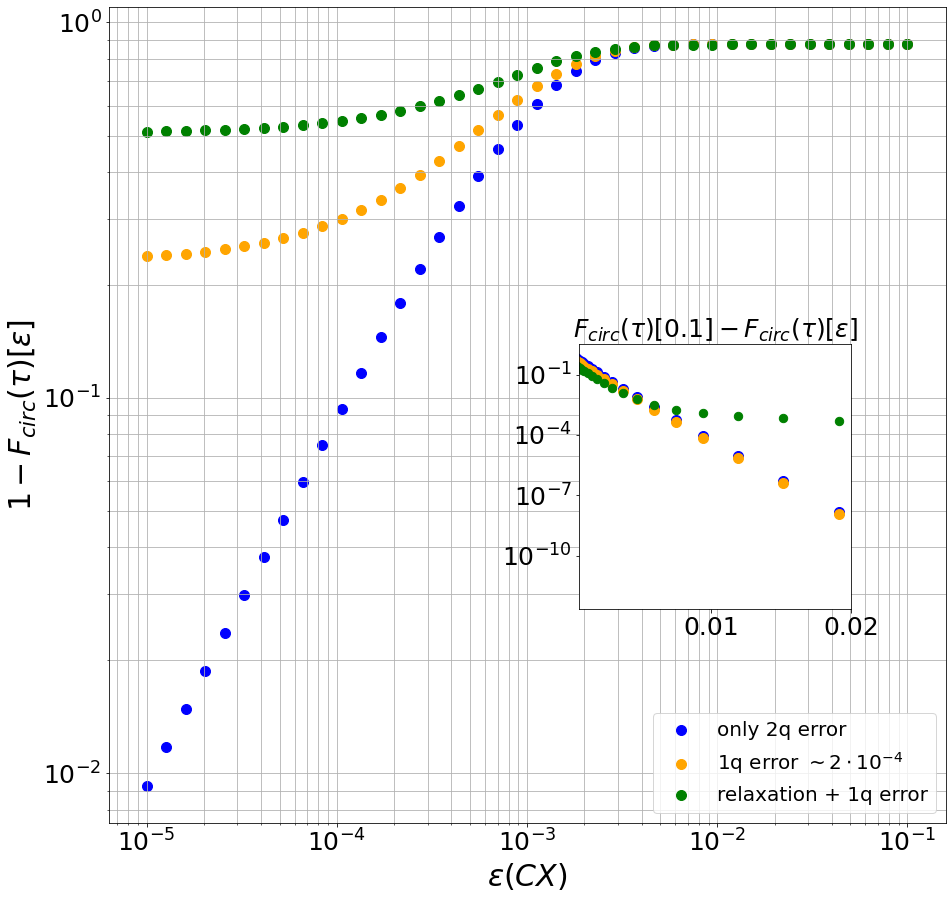

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(figsize=(15, 15))

# === Main plot: 1 - Fidelity ===
ax.scatter(cx_error_rates, infidelity, color='blue', s=100,label='only 2q error')
ax.scatter(cx_error_rates,infidelity_1qerror,color='orange',label='1q error $\sim 2 \cdot 10^{-4}$',s=100)
ax.scatter(cx_error_rates,infidelity_dec,color='green',label='relaxation + 1q error',s=100)
#ax.axvline(x=1e-3, color='red', linestyle='--', label='best CX gate error')
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim([5e-3, 0.02])
ax.set_xlabel(r'$\epsilon(CX)$', fontsize=30)
ax.set_ylabel(r'$1 - F_{circ}(\tau)[\epsilon]$', fontsize=30)
ax.tick_params(labelsize=25)
ax.grid(True, which='both')
ax.legend(fontsize=20)

# === Inset plot: Fidelity difference ===
ax_inset = inset_axes(
    ax,
    width="65%", height="65%",
    bbox_to_anchor=(0.55, 0.25, 0.5, 0.5),  # (x0, y0, width, height) in axes fraction
    bbox_transform=ax.transAxes,
    loc='lower left', borderpad=1
)

y_diff = infidelity[-1] - infidelity + 1e-12
ax_inset.scatter(cx_error_rates, y_diff, color='blue', s=100)
y_diff = infidelity_1qerror[-1] - infidelity_1qerror + 1e-12
ax_inset.scatter(cx_error_rates, y_diff, color='orange', s=100)
y_diff = infidelity_dec[-1] - infidelity_dec + 1e-12
ax_inset.scatter(cx_error_rates, y_diff, color='green', s=70)
# ax_inset.set_xscale('log')
# ax_inset.set_yscale('log')
ax_inset.set_xlim([5e-4, 0.02])
ax_inset.tick_params(labelsize=25)
ax_inset.tick_params(labelsize=25,which='minor')
ax_inset.semilogy()
ax_inset.set_title(r'$F_{circ}(\tau)[0.1] - F_{circ}(\tau)[\epsilon]$', fontsize=25)
ax_inset.semilogy()
plt.show()

-23.04538270499555 (-23.0182268493361-4.423671017940061e-15j)


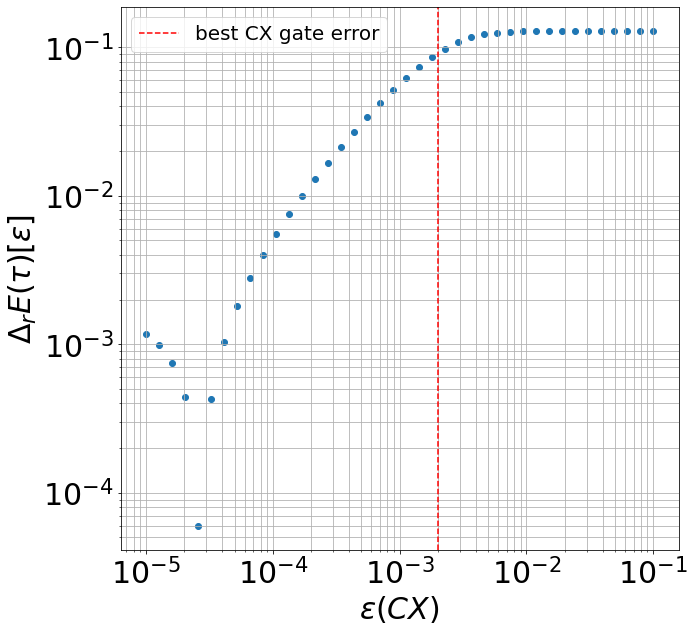

In [102]:
#plt.plot(cx_error_rates,infidelity[-1]-infidelity)
plt.figure(figsize=(10,10))
print(energy[-1],energies_vs_noise[0])
de=np.abs((energies_vs_noise-energy[-1])/energy[-1])
plt.scatter(cx_error_rates,de)

plt.axvline(x=2*10**-3,color='red',linestyle='--',label='best CX gate error')
plt.legend(fontsize=20)
plt.loglog()
plt.grid(which='minor')
plt.grid(which='major')
plt.tick_params(labelsize=30)
plt.xlabel(r'$\epsilon(CX)$',fontsize=30)
plt.ylabel(r'$\Delta_r E(\tau)[\epsilon]$',fontsize=30)

plt.show()

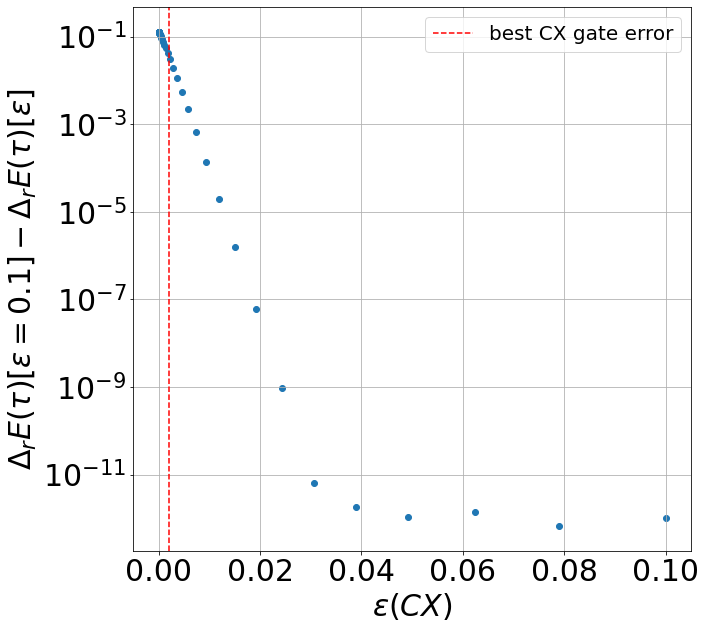

In [103]:
plt.figure(figsize=(10,10))
plt.scatter(cx_error_rates,de[-1]-de+10**-12)

plt.axvline(x=2*10**-3,color='red',linestyle='--',label='best CX gate error')
plt.legend(fontsize=20)
plt.semilogy()
plt.grid(which='minor')
plt.grid(which='major')
plt.tick_params(labelsize=30)
plt.xlabel(r'$\epsilon(CX)$',fontsize=30)
plt.ylabel(r'$\Delta_r E(\tau)[\epsilon=0.1]-\Delta_r E(\tau)[\epsilon]$',fontsize=30)

plt.show()

/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


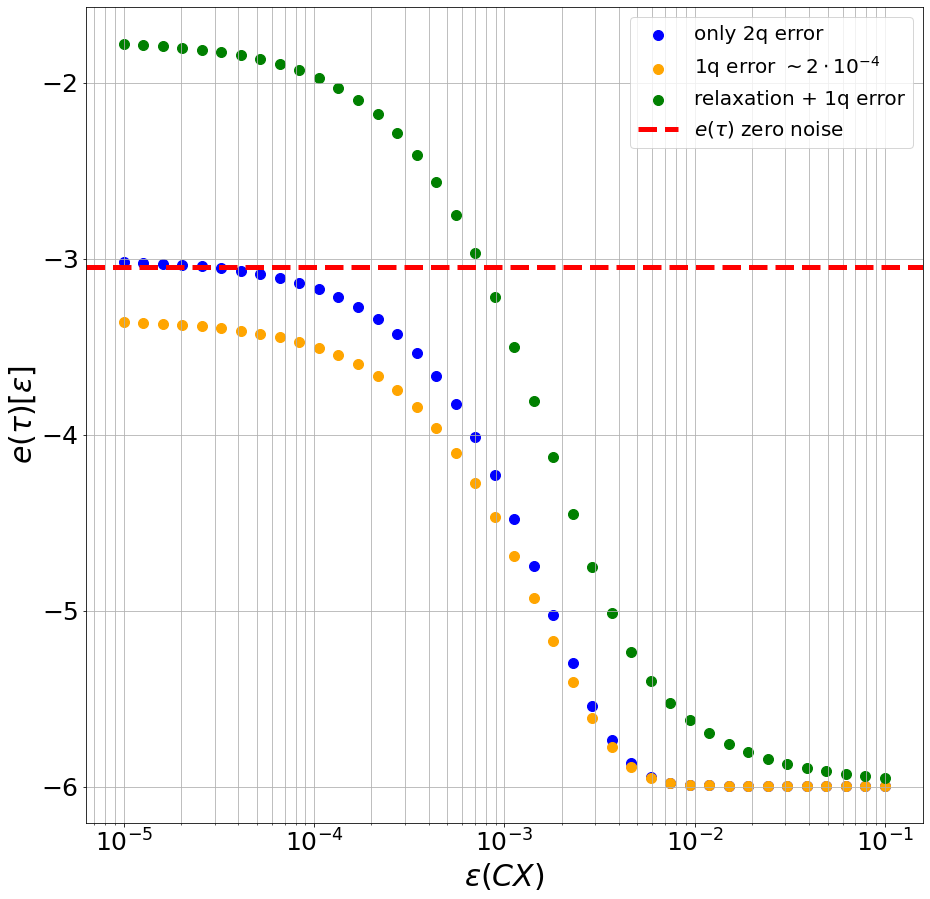

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(figsize=(15, 15))



# === Main plot: 1 - Fidelity ===
ax.scatter(cx_error_rates,( (energies_vs_noise)-binding_energy), color='blue' , s=100,label='only 2q error')
ax.scatter(cx_error_rates,( (energies_vs_noise_1qerror)-binding_energy), color='orange', label='1q error $\sim 2 \cdot 10^{-4}$', s=100)
ax.scatter(cx_error_rates,( (energies_vs_noise_dec)-binding_energy), color='green', label='relaxation + 1q error', s=100)
#ax.axvline(x=1e-3, color='red', linestyle='--', label='best CX gate error')
#ax.set_xscale('log')
#ax.set_yscale('log')2
#ax.set_xlim([5e-3, 0.02])
ax.semilogx()
ax.set_xlabel(r'$\epsilon(CX)$', fontsize=30)
ax.set_ylabel(r'$e(\tau)[\epsilon]$', fontsize=30)
ax.tick_params(labelsize=25)
ax.tick_params(labelsize=25,which='minor')
ax.axhline(y=(energy[-1]-binding_energy), label=r'$e(\tau)$ zero noise',linestyle='--',color='red',linewidth=5)
ax.grid(True, which='both')
ax.legend(fontsize=20)

# # === Inset plot: Fidelity difference ===
# ax_inset = inset_axes(
#     ax,
#     width="65%", height="65%",
#     bbox_to_anchor=(0.55, 0.25, 0.5, 0.5),  # (x0, y0, width, height) in axes fraction
#     bbox_transform=ax.transAxes,
#     loc='lower left', borderpad=1
# )

# y_diff = np.abs(energies_vs_noise[-1] - energies_vs_noise) + 1e-12
# ax_inset.scatter(cx_error_rates, y_diff, color='blue', s=100)
# y_diff = np.abs(energies_vs_noise_1qerror[-1] - energies_vs_noise_1qerror) + 1e-12
# ax_inset.scatter(cx_error_rates, y_diff, color='orange', s=100)
# y_diff = np.abs(energies_vs_noise_dec[-1] - energies_vs_noise_dec) + 1e-12
# ax_inset.scatter(cx_error_rates, y_diff, color='green', s=70)
# # ax_inset.set_xscale('log')
# # ax_inset.set_yscale('log')
# ax_inset.set_xlim([5e-4, 0.02])
# ax_inset.tick_params(labelsize=25)
# ax_inset.tick_params(labelsize=25,which='minor')
# ax_inset.semilogy()
# ax_inset.set_title(r'$  e(\tau)[0.1] -  e(\tau)[\epsilon]$', fontsize=25)
# ax_inset.semilogy()

plt.show()

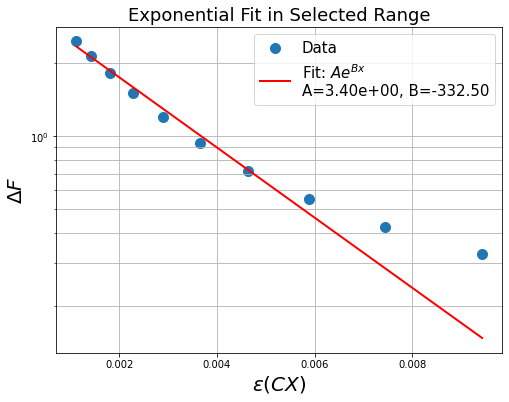

In [24]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Prepare data
x = np.array(cx_error_rates)
y = np.abs(energies_vs_noise_dec[-1] - energies_vs_noise_dec) + 1e-12

# Select range
mask = (x >= 1e-3) & (x <= 1e-2)
x_fit = x[mask]
y_fit = y[mask]

# Define exponential model: y = A * exp(B * x)
def exp_model(x, A, B):
    return A * np.exp(B * x)

# Fit the model
popt, pcov = curve_fit(exp_model, x_fit, y_fit, p0=(1e-3, -100))  # initial guess

A_fit, B_fit = popt

# Generate smooth curve for plotting
x_smooth = np.linspace(min(x_fit), max(x_fit), 300)
y_smooth = exp_model(x_smooth, *popt)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x_fit, y_fit, label='Data', s=100)
plt.plot(x_smooth, y_smooth, label=fr'Fit: $A e^{{B x}}$' + f'\nA={A_fit:.2e}, B={B_fit:.2f}', color='red', linewidth=2)
plt.xlabel(r'$\epsilon(CX)$', fontsize=20)
plt.ylabel(r'$\Delta F$', fontsize=20)
plt.semilogy()
plt.grid(True, which='both')
plt.legend(fontsize=15)
plt.title('Exponential Fit in Selected Range', fontsize=18)
plt.show()

In [95]:
# Predict y values using the fit
y_pred = exp_model(x_fit, *popt)

# Compute R^2
residuals = y_fit - y_pred
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_fit - np.mean(y_fit))**2)
r_squared = 1 - (ss_res / ss_tot)

print(f"R^2 = {r_squared:.10f}")

R^2 = 0.9818811025


In [96]:
print(np.abs( (energies_vs_noise[-1]+A_fit)-energy[-1])/energy[-1])

-0.041070368696889244


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


[0.00854776+4.35474306e-18j 0.00960974-2.96133043e-16j
 0.01095133-1.18205972e-16j 0.01264502-2.74834713e-16j
 0.01478145+4.86913640e-16j 0.01747354+8.25399058e-17j
 0.02086132+3.98637064e-16j 0.0251174 +2.05537801e-16j
 0.03045297-3.90784180e-16j 0.03712385+5.44910067e-16j
 0.0454358 +4.32653729e-16j 0.05574793+7.41473700e-16j
 0.0684718 +5.20441031e-17j 0.08406319-4.88356417e-16j
 0.10300167+2.29364052e-16j 0.1257521 -7.46602660e-17j
 0.15270087-3.97310910e-16j 0.18406085-1.07196542e-17j
 0.21974327+5.42770477e-16j 0.25920626+9.48110460e-17j
 0.30130959+4.04422832e-17j 0.34423454+1.78014392e-16j
 0.38555491+8.87484189e-17j 0.42254738+6.41068128e-18j
 0.45276639-8.48286825e-17j 0.47475713-3.06403239e-16j
 0.4885889 -1.41064580e-16j 0.4958286 -2.65562112e-16j
 0.49883545-4.53973867e-17j 0.49976915+4.24144944e-17j
 0.49997038+5.55505464e-17j 0.49999782-5.04250085e-17j
 0.49999992-3.41444240e-17j 0.5       +7.91842911e-17j
 0.5       -6.62121592e-18j 0.5       -4.17579244e-17j
 0.5      

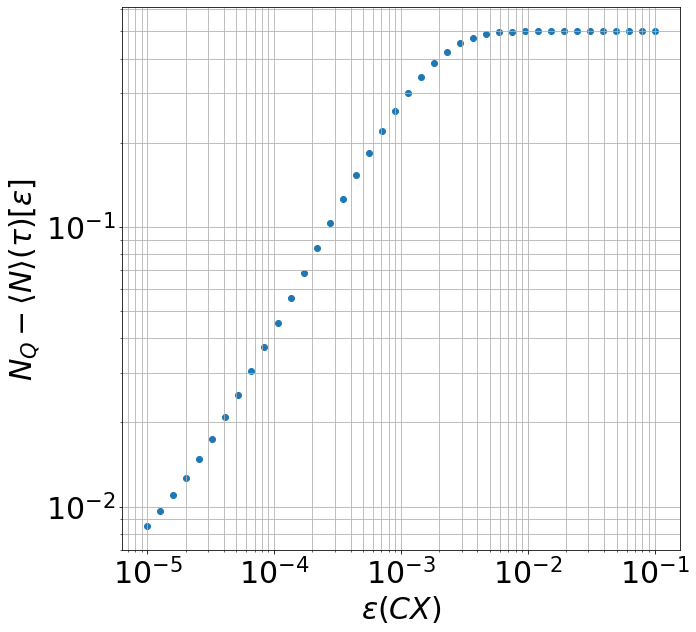

In [97]:
#plt.plot(cx_error_rates,infidelity[-1]-infidelity)
plt.figure(figsize=(10,10))

plt.scatter(cx_error_rates,conservation_check)
print(conservation_check)
#plt.axvline(x=2*10**-3,color='red',linestyle='--',label='best CX gate error')
#plt.legend(fontsize=20)
plt.loglog()
plt.grid(which='minor')
plt.grid(which='major')
plt.tick_params(labelsize=30)
plt.xlabel(r'$\epsilon(CX)$',fontsize=30)
plt.ylabel(r'$N_Q- \langle N \rangle (\tau)[\epsilon]$',fontsize=30)

plt.show()

#### Extrapolate the error

In [54]:

#final_state=Statevector(circuit_opt)
time_steps=20
tf=2
time=np.linspace(0,tf,time_steps)
dt=tf/time_steps
#b=0.8
#h=1-(1+b)*(time/tf)+b*(time/tf)**2
h=1-time/tf
circuit_time_evolution=QuantumCircuit(hamiltonian_q.num_qubits)
circuit_time_evolution.x([0]) # initial state

energies_qiskit=np.zeros((time_steps))


for n,t in enumerate(time):
    hamiltonian_t=(h[n])*hamiltonian_driver+(1-h[n])*hamiltonian_q
    exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
    #exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=QDrift(reps=5))
    circuit_time_evolution.append(exp_H_t,range(hamiltonian_q.num_qubits))
    single_particle_vector=np.zeros(2**n_qubits,dtype=np.complex128)
    psi_for_fidelity=np.zeros(n_qubits,dtype=np.complex128)
    for a in range(n_qubits):
        a_mb=2**(a)
        final_state=Statevector(circuit_time_evolution).data
        single_particle_vector[a_mb]=final_state[a_mb]
        psi_for_fidelity[a]=final_state[a_mb]
    energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)

transpiled_circuit_time_evolution=transpile(circuit_time_evolution.decompose(), optimization_level=3,basis_gates=['cx','s','h','rz','x'])
final_state=Statevector(circuit_time_evolution)

print(final_state.expectation_value(hamiltonian_q))

/tmp/ipykernel_2362206/3721214493.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


(0.05577912244282501+0j)


In [55]:
transpiled_circuit_time_evolution.save_density_matrix()

In [56]:
from qiskit import QuantumCircuit
from copy import deepcopy


def amplify_cnots_qiskit(circuit, cnot_multiples=[0, 4, 6,8,10]):
    """
    Amplify noise in a Qiskit circuit by repeating each CNOT gate multiple (even) times.
    Returns a list of new circuits with amplified CNOTs.
    """
    amplified_circuits = []

    for m in cnot_multiples:
        new_circuit = QuantumCircuit(circuit.num_qubits, circuit.num_clbits)

        for instr, qargs, cargs in circuit.data:
            if instr.name == "cx":
                control = circuit.find_bit(qargs[0]).index
                target = circuit.find_bit(qargs[1]).index
                for _ in range(m + 1):  # original + m times
                    new_circuit.cx(control, target)
            else:
                new_circuit.append(deepcopy(instr), qargs, cargs)

        amplified_circuits.append(new_circuit)

    return amplified_circuits

Noise model

In [57]:
amplified_circuits=amplify_cnots_qiskit(transpiled_circuit_time_evolution)
energies_vs_noise_dec=[]
infidelity_dec=[]
for circuit in amplified_circuits:

    # Create a noise model
    noise_model = NoiseModel()
    t1 = 197 * 10**-6  # 225.54 us to ns
    t2 = 119 * 10**-6  # 183.22 us to ns
    gate_time=68*10**-9
    # Add gate errors
    cx_depol = depolarizing_error(2.68*10**-3, 2)
    rz_depol = depolarizing_error(2e-4, 1)
    #x_depol = depolarizing_error(1e-4, 1)
    h_depol = depolarizing_error(2.024e-4, 1)
    # Add depolarizing errors
    noise_model.add_all_qubit_quantum_error(cx_depol, 'cx')
    noise_model.add_all_qubit_quantum_error(rz_depol, 'rz')
    #noise_model.add_all_qubit_quantum_error(x_depol, 'x')
    noise_model.add_all_qubit_quantum_error(h_depol, 'h')


    # Add thermal relaxation errors
    thermal_1q = thermal_relaxation_error(t1, t2, gate_time)
    # thermal_2q = thermal_relaxation_error(t1, t2, gate_time_2q)

    for gate in ['h', 'rz', 'x']:
        noise_model.add_all_qubit_quantum_error(thermal_1q, gate)
    #trnoise_model.add_all_qubit_quantum_error(thermal_2q, 'cz')



    sim = AerSimulator(noise_model=noise_model)
    
    # Transpile and run
    tqc = transpile(circuit, sim,optimization_level=0)
    result = sim.run(tqc).result()


    dm = result.data(0)['density_matrix']
    final_state_with_noise=DensityMatrix(dm)
    eng_tau=final_state_with_noise.expectation_value(hamiltonian_q)
    n_conservation=final_state_with_noise.expectation_value(n_operator)-1
    f_tau=state_fidelity(final_state_with_noise,final_state)
    print(1-f_tau)
    print(eng_tau,'\n')
    energies_vs_noise_dec.append(eng_tau)
    infidelity_dec.append(1-f_tau)


energies_vs_noise_dec=np.asarray(energies_vs_noise_dec)
infidelity_dec=np.asarray(infidelity_dec)


/tmp/ipykernel_3214891/3413160716.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


0.7358385820760752
(-24.013364356180972-2.486305880643727e-16j) 



0.8731105378559089
(-25.668578201354613-5.978944637119665e-17j) 



0.8741314546152974
(-25.768191024139757-7.335947910703983e-17j) 



0.8743707465021694
(-25.816754407093057+7.611478918985254e-17j) 

0.874487515483291
(-25.846708530273393+8.271213668865707e-18j) 



ValueError: x and y must have same first dimension, but have shapes (3,) and (5,)

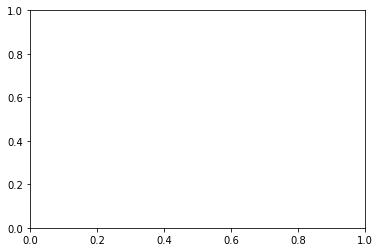

In [37]:
errors=np.array([1,3,5,])*2.68*10**-3

plt.plot(errors,energies_vs_noise_dec-energies_vs_noise_dec[-1])
plt.semilogy()
plt.show()

/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


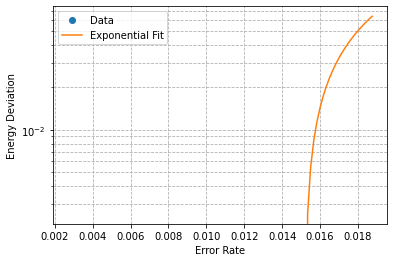

807.5080429979848


In [111]:
import numpy as np
import matplotlib.pyplot as plt

# X-axis: errors (amplification levels)
errors = np.array([1, 3, 5,7]) * 2.68e-3

# Y-axis: energy deviations (your data)
# Replace with your actual energy values
energy_values = np.array(energies_vs_noise_dec)
energy_deviation = energy_values - energy_values[-1]  # subtract asymptotic (lowest noise) energy

from scipy.optimize import curve_fit

# Exponential decay model
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

# Fit the curve
params, _ = curve_fit(exp_decay, errors, energy_deviation, p0=(1, 1, 0))
a_fit, b_fit, c_fit = params

# Plot original data
plt.plot(errors, energy_deviation, 'o', label='Data')

# Plot fitted exponential
x_fit = np.linspace(min(errors), max(errors), 100)
y_fit = exp_decay(x_fit, a_fit, b_fit, c_fit)
plt.plot(x_fit, y_fit, '-', label='Exponential Fit')

# Log scale for y-axis
plt.semilogy()
plt.xlabel('Error Rate')
plt.ylabel('Energy Deviation')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.show()

print(a_fit)

In [30]:
from scipy.optimize import curve_fit
import numpy as np

# Model and fit
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

params, _ = curve_fit(exp_decay, errors, energy_deviation, p0=(1, 1, 0))
a_fit, b_fit, c_fit = params

# Predicted values
y_pred = exp_decay(errors, a_fit, b_fit, c_fit)

# Actual values
y_true = energy_deviation

# Compute R^2
ss_res = np.sum((y_true - y_pred) ** 2)
ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

print(f"R² = {r_squared:.4f}")

R² = 0.9984+0.0000j


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)


#### ZNE for different $\tau \omega$

In [46]:
from qiskit import QuantumCircuit
from copy import deepcopy


def amplify_cnots_qiskit(circuit, cnot_multiples=[0,2, 4,6]):
    """
    Amplify noise in a Qiskit circuit by repeating each CNOT gate multiple (even) times.
    Returns a list of new circuits with amplified CNOTs.
    """
    amplified_circuits = []

    for m in cnot_multiples:
        new_circuit = QuantumCircuit(circuit.num_qubits, circuit.num_clbits)

        for instr, qargs, cargs in circuit.data:
            if instr.name == "cx":
                control = circuit.find_bit(qargs[0]).index
                target = circuit.find_bit(qargs[1]).index
                for _ in range(m + 1):  # original + m times
                    new_circuit.cx(control, target)
            else:
                new_circuit.append(deepcopy(instr), qargs, cargs)

        amplified_circuits.append(new_circuit)

    return amplified_circuits

In [47]:

#final_state=Statevector(circuit_opt)
errors_vs_tf=[]
infidelities_vs_tf=[]
energies_vs_tf=[]
tfs=np.linspace(0.1,5,20)
for tf in tfs:
    time_steps=int(tf*10)
    time=np.linspace(0,tf,time_steps)
    dt=tf/time_steps
    #b=0.8
    #h=1-(1+b)*(time/tf)+b*(time/tf)**2
    h=1-time/tf
    circuit_time_evolution=QuantumCircuit(hamiltonian_q.num_qubits)
    circuit_time_evolution.x([0]) # initial state

    energies_qiskit=np.zeros((time_steps))


    for n,t in enumerate(time):
        hamiltonian_t=(h[n])*hamiltonian_driver+(1-h[n])*hamiltonian_q
        exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
        #exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=QDrift(reps=5))
        circuit_time_evolution.append(exp_H_t,range(hamiltonian_q.num_qubits))
        single_particle_vector=np.zeros(2**n_qubits,dtype=np.complex128)
        psi_for_fidelity=np.zeros(n_qubits,dtype=np.complex128)
        for a in range(n_qubits):
            a_mb=2**(a)
            final_state=Statevector(circuit_time_evolution).data
            single_particle_vector[a_mb]=final_state[a_mb]
            psi_for_fidelity[a]=final_state[a_mb]
        energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)

    transpiled_circuit_time_evolution=transpile(circuit_time_evolution.decompose(), optimization_level=3,basis_gates=['cx','s','h','rz','x'])
    final_state=Statevector(circuit_time_evolution)

    transpiled_circuit_time_evolution.save_density_matrix()
    print(f'energies ={final_state.expectation_value(hamiltonian_q)} at tau={tf}')

    amplified_circuits=amplify_cnots_qiskit(transpiled_circuit_time_evolution)
    energies_vs_noise_dec=[]
    infidelity_dec=[]
    for m,circuit in enumerate(amplified_circuits):

        # Create a noise model
        noise_model = NoiseModel()
        t1 = 197 * 10**-6  # 225.54 us to ns
        t2 = 119 * 10**-6  # 183.22 us to ns
        gate_time=68*10**-9
        # Add gate errors
        cx_depol = depolarizing_error(2.68*10**-3, 2)
        rz_depol = depolarizing_error(2e-4, 1)
        #x_depol = depolarizing_error(1e-4, 1)
        h_depol = depolarizing_error(2.024e-4, 1)
        
        thermal_1q = thermal_relaxation_error(t1, t2, gate_time)
        
        #cx_depol.compose(thermal_1q)
        rz_error=rz_depol.compose(thermal_1q)
        h_error=h_depol.compose(thermal_1q)
        
        # Add depolarizing errors
        noise_model.add_all_qubit_quantum_error(cx_depol, 'cx')
        noise_model.add_all_qubit_quantum_error(rz_error, 'rz')
        #noise_model.add_all_qubit_quantum_error(x_depol, 'x')
        noise_model.add_all_qubit_quantum_error(h_error, 'h')

        # print(
        #     f"""
        #     amplification:{m}
        #     Nonlocal gate count: {circuit.num_nonlocal_gates()}
        #         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

        # """
        # )
        # Add thermal relaxation errors

        # thermal_2q = thermal_relaxation_error(t1, t2, gate_time_2q)

        # for gate in ['h', 'rz', 'x']:
        #     noise_model.add_all_qubit_quantum_error(thermal_1q, gate)
        # #trnoise_model.add_all_qubit_quantum_error(thermal_2q, 'cz')



        sim = AerSimulator(noise_model=noise_model)
        
        # Transpile and run
        tqc = transpile(circuit, sim,optimization_level=0)
        result = sim.run(tqc).result()


        dm = result.data(0)['density_matrix']
        final_state_with_noise=DensityMatrix(dm)
        eng_tau=final_state_with_noise.expectation_value(hamiltonian_q)
        n_conservation=final_state_with_noise.expectation_value(n_operator)-1
        f_tau=state_fidelity(final_state_with_noise,final_state)
        #print(1-f_tau)
        #print(eng_tau,'\n')
        energies_vs_noise_dec.append(eng_tau)
        infidelity_dec.append(1-f_tau)

    print(f'energies with noise={energies_vs_noise_dec[0]} 1-f with noise={infidelity_dec[0]} \n')
    energies_vs_noise_dec=np.asarray(energies_vs_noise_dec)
    infidelity_dec=np.asarray(infidelity_dec)
    
    errors_vs_tf.append(energies_vs_noise_dec)
    infidelities_vs_tf.append(infidelity_dec)
    energies_vs_tf.append(final_state.expectation_value(hamiltonian_q))
    
errors_vs_tf=np.asarray(errors_vs_tf)
infidelities_vs_tf=np.asarray(infidelities_vs_tf)
energies_vs_tf=np.asarray(energies_vs_tf)

/tmp/ipykernel_1973246/2917305734.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)
/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies =(-18.4321+0j) at tau=0.1
energies with noise=(-18.399622003307403+0j) 1-f with noise=0.0017620345317459485 

energies =(-18.66578609408018+0j) at tau=0.35789473684210527


/tmp/ipykernel_1973246/2917305734.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)
/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(-18.957240122983656-1.7890322427919042e-16j) 1-f with noise=0.06659428152732927 

energies =(-20.39012934141718+0j) at tau=0.6157894736842106


/tmp/ipykernel_1973246/2917305734.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)
/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(-20.807955776749335-2.0184270637710534e-15j) 1-f with noise=0.15538087835547665 

energies =(-21.098786812601986+0j) at tau=0.8736842105263158


/tmp/ipykernel_1973246/2917305734.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)
/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(-21.56096066133734+9.26776813999426e-16j) 1-f with noise=0.20871438250453367 



/tmp/ipykernel_1973246/2917305734.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-21.535128455069863+0j) at tau=1.1315789473684212


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(-22.090913248263718-4.854019547409157e-16j) 1-f with noise=0.28053874117033306 



/tmp/ipykernel_1973246/2917305734.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-21.955622177908246+0j) at tau=1.3894736842105266


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(-22.48610539726611-3.261371057671325e-16j) 1-f with noise=0.32487256665007935 



/tmp/ipykernel_1973246/2917305734.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-22.24899255356168+0j) at tau=1.6473684210526318


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(-22.804355851394583-1.200276022044031e-16j) 1-f with noise=0.38411056338032334 



/tmp/ipykernel_1973246/2917305734.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-22.435391891926788+0j) at tau=1.905263157894737


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(-23.024238610966655+3.332018537157468e-16j) 1-f with noise=0.43671928137888005 



/tmp/ipykernel_1973246/2917305734.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-22.62616784586686+0j) at tau=2.1631578947368424


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(-23.19189152478028-2.9328265302241896e-16j) 1-f with noise=0.468975993689038 



/tmp/ipykernel_1973246/2917305734.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-22.708558268255327+0j) at tau=2.421052631578948


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(-23.32439220081465+8.81494921272235e-16j) 1-f with noise=0.5122741899193741 



/tmp/ipykernel_1973246/2917305734.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-22.809878897996978+0j) at tau=2.678947368421053


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(-23.428011999090973+7.860533798207957e-16j) 1-f with noise=0.5386228114442979 



/tmp/ipykernel_1973246/2917305734.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-22.86233734396125+0j) at tau=2.936842105263158


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(-23.5267189479021+2.1705959300667313e-16j) 1-f with noise=0.5743689831249009 



/tmp/ipykernel_1973246/2917305734.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-22.907101330993417+0j) at tau=3.1947368421052635


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(-23.59785943907309-8.115648033507433e-16j) 1-f with noise=0.5960109816120148 



/tmp/ipykernel_1973246/2917305734.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-22.936636287628822+0j) at tau=3.452631578947369


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(-23.676605167695797-3.7639657778649e-16j) 1-f with noise=0.6253950779679446 



/tmp/ipykernel_1973246/2917305734.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-22.959981548894977+0j) at tau=3.710526315789474


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(-23.74879126377405+1.367293694301177e-15j) 1-f with noise=0.6515649350215604 



/tmp/ipykernel_1973246/2917305734.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-22.969693874217683+0j) at tau=3.9684210526315793


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(-23.799128154643256+1.0242083062291045e-15j) 1-f with noise=0.6674503112367312 



/tmp/ipykernel_1973246/2917305734.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-22.984494831664584+0j) at tau=4.226315789473684


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(-23.86180867644455+3.1553201771930225e-16j) 1-f with noise=0.6890318464229687 



/tmp/ipykernel_1973246/2917305734.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-22.984296217722413+0j) at tau=4.484210526315789


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(-23.905265484390668-3.0720956915268065e-16j) 1-f with noise=0.7021495690181407 



/tmp/ipykernel_1973246/2917305734.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-22.992812022451247+0j) at tau=4.742105263157895


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(-23.96126012760084-9.622080826084229e-16j) 1-f with noise=0.7199515544907639 



/tmp/ipykernel_1973246/2917305734.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-22.9961803567151+0j) at tau=5.0


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(-24.013364356180972-2.486305880643727e-16j) 1-f with noise=0.7358385820760752 



In [48]:
print(errors_vs_tf)

[[-18.399622  +0.00000000e+00j -18.399622  +0.00000000e+00j
  -18.399622  +0.00000000e+00j -18.399622  +0.00000000e+00j]
 [-18.95724012-1.78903224e-16j -19.50087576-6.82654397e-16j
  -20.00404033+4.09809738e-17j -20.46953192-5.38541466e-16j]
 [-20.80795578-2.01842706e-15j -21.65043059+4.46960205e-16j
  -22.36680659+3.62035882e-16j -22.97241877+2.99300229e-16j]
 [-21.56096066+9.26776814e-16j -22.51699959-5.84046851e-16j
  -23.28019079-1.43231031e-16j -23.8832199 -1.88952820e-16j]
 [-22.09091325-4.85401955e-16j -23.22150861+8.82543165e-17j
  -24.03839964+4.73241038e-17j -24.61829866-3.87773014e-16j]
 [-22.4861054 -3.26137106e-16j -23.64005978-2.44549542e-16j
  -24.42959352-3.22169265e-16j -24.95515495+2.44755476e-16j]
 [-22.80435585-1.20027602e-16j -24.03549467-9.17329612e-16j
  -24.80111317-2.61947661e-16j -25.25995929+6.74716502e-17j]
 [-23.02423861+3.33201854e-16j -24.32272729+6.48083912e-16j
  -25.05308165+1.50538510e-18j -25.44679097+1.11913290e-16j]
 [-23.19189152-2.93282653e-16j -

In [49]:
print(
    f"""
Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: {transpiled_circuit_time_evolution.depth()}
             Gate count: {len(transpiled_circuit_time_evolution)}
    Nonlocal gate count: {transpiled_circuit_time_evolution.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in transpiled_circuit_time_evolution.count_ops().items()])}

"""
)



# And finall
%matplotlib inline
#initial_state.draw("text")


Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: 1181
             Gate count: 1770
    Nonlocal gate count: 588
         Gate breakdown: RZ: 591, H: 590, CX: 588, SAVE_DENSITY_MATRIX: 1




Analysis

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Example setup — replace with your actual data
errors = np.array([1, 3, 5,7]) * 2.68e-3  # [num_noise_levels]


def streached_exp_decay(x, a, b,c):
    return a * np.exp(-b * x**c) 

def exp_decay(x, a, b):
    return a * np.exp(-b * x) 



# To store fitted parameters
fit_params=[]

print(errors_vs_tf.shape)
shift_values_streached=[]
shift_values=[]
for i, energy_values in enumerate(errors_vs_tf[1:]):
    print(energy_values)
    energy_deviation = (energy_values-energy_values[-1])

    try:
        params_streached, _ = curve_fit(streached_exp_decay, errors[:-1], energy_deviation[:-1], p0=(1, 1,-0.1))
        a_fit_streached, b_fit_streached ,c_fit_streached= params_streached


        # Plot
        x_fit = np.linspace(min(errors), max(errors), 100)
        y_fit = streached_exp_decay(x_fit, a_fit_streached, b_fit_streached, c_fit_streached)
        # plt.plot(errors, energy_deviation, 'o', label=f'Data tf={tfs[i+1]}')
        # plt.plot(x_fit, y_fit, '-', label=f'Fit tf={tfs[i+1]}, a fit={a_fit_streached} {errors_vs_tf[i,-1]}')
        # # Final plot settings
        # plt.semilogy()
        # plt.xlabel("Error Rate")
        # plt.ylabel("Energy Deviation")
        # plt.legend()
        # plt.grid(True, which='both', ls='--')
        # plt.title("Streached Exponential Fits of Energy Deviation vs Error Rate")
        # plt.tight_layout()
        # plt.show()
        
        params, _ = curve_fit(exp_decay, errors[:-1], energy_deviation[:-1], p0=(1, 1))
        a_fit, b_fit = params
        fit_params.append(params)

        # Plot
        x_fit = np.linspace(min(errors), max(errors), 100)
        y_fit = exp_decay(x_fit, a_fit, b_fit)
        # plt.plot(errors, energy_deviation, 'o', label=f'Data tf={tfs[i+1]}')
        # plt.plot(x_fit, y_fit, '-', label=f'Fit tf={tfs[i+1]}, a fit={a_fit} {errors_vs_tf[i,-1]}')
        # # Final plot settings
        # plt.semilogy()
        # plt.xlabel("Error Rate")
        # plt.ylabel("Energy Deviation")
        # plt.legend()
        # plt.grid(True, which='both', ls='--')
        # plt.title("Streached Exponential Fits of Energy Deviation vs Error Rate")
        # plt.tight_layout()
        # plt.show()
        
        
        
    
    except RuntimeError:
        print(f"Fit failed for tf index {i}")
        fit_params.append((np.nan, np.nan, np.nan))
     


    # Predicted values
    y_pred_streached = streached_exp_decay(errors, a_fit_streached, b_fit_streached,c_fit_streached)
    y_pred=exp_decay(errors, a_fit, b_fit)
    # Actual values
    y_true = energy_deviation

    # Compute R^2
    ss_res_streached = np.sum((y_true - y_pred_streached) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r_squared_streached = 1 - (ss_res_streached / ss_tot)
    r_squared = 1 - (ss_res / ss_tot)
    print(f"R² = {r_squared_streached:.8f},{r_squared:.8f}")

    shift_values_streached.append(a_fit_streached) 
    shift_values.append(a_fit) 
      
    # if r_squared<0.999:
    #     shift_values.append(a_fit_streached)
    # else:
    #     shift_values.append(a_fit)

# Convert parameters to NumPy array for further use
fit_params = np.array(fit_params)



(20, 4)
[-18.95724012-1.78903224e-16j -19.50087576-6.82654397e-16j
 -20.00404033+4.09809738e-17j -20.46953192-5.38541466e-16j]
R² = 0.97589138+0.00000000j,0.91824372+0.00000000j
[-20.80795578-2.01842706e-15j -21.65043059+4.46960205e-16j
 -22.36680659+3.62035882e-16j -22.97241877+2.99300229e-16j]
R² = 0.98168699-0.00000000j,0.93661038-0.00000000j
[-21.56096066+9.26776814e-16j -22.51699959-5.84046851e-16j
 -23.28019079-1.43231031e-16j -23.8832199 -1.88952820e-16j]
R² = 0.98525237+0.00000000j,0.94811546+0.00000000j
[-22.09091325-4.85401955e-16j -23.22150861+8.82543165e-17j
 -24.03839964+4.73241038e-17j -24.61829866-3.87773014e-16j]
R² = 0.98972098-0.00000000j,0.96284896-0.00000000j
[-22.4861054 -3.26137106e-16j -23.64005978-2.44549542e-16j
 -24.42959352-3.22169265e-16j -24.95515495+2.44755476e-16j]
R² = 0.99181086-0.00000000j,0.96952753-0.00000000j
[-22.80435585-1.20027602e-16j -24.03549467-9.17329612e-16j
 -24.80111317-2.61947661e-16j -25.25995929+6.74716502e-17j]
R² = 0.99443322-0.00000

/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/tmp/ipykernel_1973246/4074759943.py:10: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x**c)
/tmp/ipykernel_1973246/4074759943.py:28: OptimizeWarning: Covariance of the parameters could not be estimated
  params_streached, _ = curve_fit(streached_exp_decay, errors[:-1], energy_deviation[:-1], p0=(1, 1,-0.1))


In [58]:
energy_zne_vs_tf_streached=[]
energy_zne_vs_tf=[]

tfs_zne=[]

for i in range(1,tfs.shape[0]):
    tfs_zne.append(tfs[i])
    print(errors_vs_tf[i])
    print('estimation=',errors_vs_tf[i,-1]+shift_values[i-1],shift_values[i-1],'exact=',energies_vs_tf[i],'without zne=',errors_vs_tf[i,-1],'tf=',tfs[i],'\n')
    energy_zne_vs_tf.append(errors_vs_tf[i,-1]+shift_values[i-1])
    energy_zne_vs_tf_streached.append(errors_vs_tf[i,-1]+shift_values_streached[i-1])
    
    

[-18.95724012-1.78903224e-16j -19.50087576-6.82654397e-16j
 -20.00404033+4.09809738e-17j -20.46953192-5.38541466e-16j]
estimation= (-18.466411200248658-5.385414659885972e-16j) 2.0031207164291462 exact= (-18.66578609408018+0j) without zne= (-20.469531916677802-5.385414659885972e-16j) tf= 0.35789473684210527 

[-20.80795578-2.01842706e-15j -21.65043059+4.46960205e-16j
 -22.36680659+3.62035882e-16j -22.97241877+2.99300229e-16j]
estimation= (-20.047088455593045+2.99300228540942e-16j) 2.925330316296928 exact= (-20.39012934141718+0j) without zne= (-22.972418771889973+2.99300228540942e-16j) tf= 0.6157894736842106 

[-21.56096066+9.26776814e-16j -22.51699959-5.84046851e-16j
 -23.28019079-1.43231031e-16j -23.8832199 -1.88952820e-16j]
estimation= (-20.694243250530366-1.8895282046406824e-16j) 3.1889766524762 exact= (-21.098786812601986+0j) without zne= (-23.883219903006566-1.8895282046406824e-16j) tf= 0.8736842105263158 

[-22.09091325-4.85401955e-16j -23.22150861+8.82543165e-17j
 -24.03839964+4.

Plot of the QA protocol at different $\tau \omega$ with ZNE and without

/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the

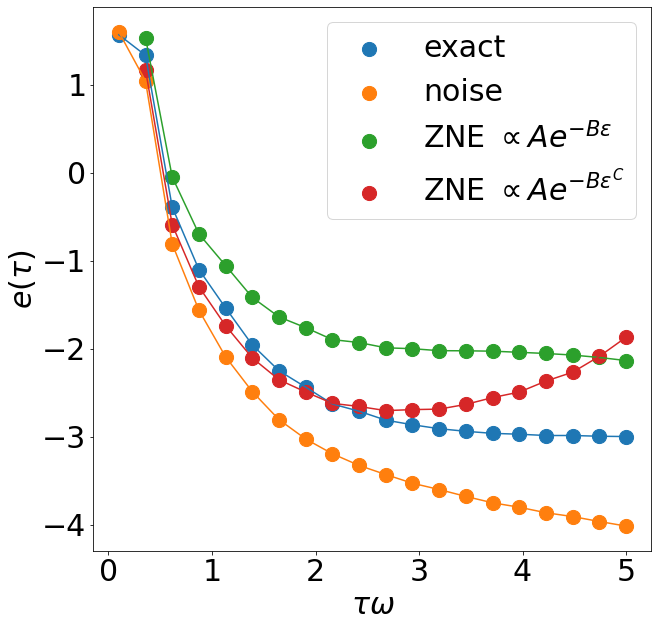

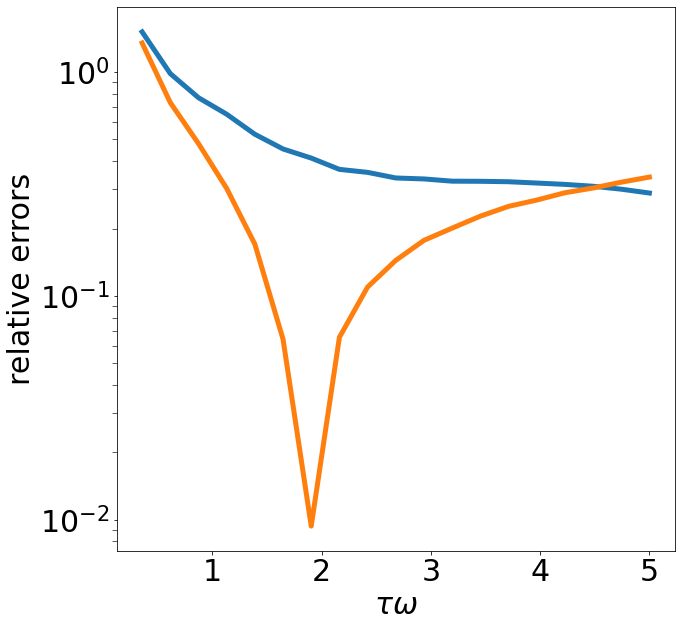

In [62]:
energy_zne_vs_tf=np.asarray(energy_zne_vs_tf)
energy_zne_vs_tf_streached=np.asarray(energy_zne_vs_tf_streached)
plt.figure(figsize=(10,10))
plt.plot(tfs,energies_vs_tf-binding_energy)
plt.scatter(tfs,energies_vs_tf-binding_energy,s=200,label='exact')
plt.plot(tfs,errors_vs_tf[:,0]-binding_energy)
plt.scatter(tfs,errors_vs_tf[:,0]-binding_energy,s=200,label='noise')
plt.plot(tfs_zne,energy_zne_vs_tf-binding_energy)
plt.scatter(tfs_zne,energy_zne_vs_tf-binding_energy,s=200,label=r'ZNE $\propto A e^{-B \epsilon}$')
plt.scatter(tfs_zne,energy_zne_vs_tf_streached-binding_energy,s=200,label=r'ZNE $\propto A e^{-B \epsilon^C}$')
plt.plot(tfs_zne,energy_zne_vs_tf_streached-binding_energy)
plt.tick_params(which='major',labelsize=30)
plt.legend(fontsize=30)
plt.xlabel(r'$\tau \omega$',fontsize=30)
plt.ylabel(r'$e(\tau)$',fontsize=30)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(tfs[1:],np.abs(energy_zne_vs_tf-energies_vs_tf[-1])/np.abs(energies_vs_tf[-1]-binding_energy),linewidth=5)
plt.plot(tfs[1:],np.abs(errors_vs_tf[1:,0]-energies_vs_tf[-1])/np.abs(energies_vs_tf[-1]-binding_energy),linewidth=5)
plt.semilogy()
plt.tick_params(which='major',labelsize=30)
plt.tick_params(which='minor',labelsize=30,length=5)
plt.xlabel(r'$\tau \omega$',fontsize=30)
plt.ylabel(r'relative errors',fontsize=30)
plt.show()

#### ZNE for the number of particles

In [64]:

#final_state=Statevector(circuit_opt)
n_errors_vs_tf=[]
infidelities_vs_tf=[]
n_vs_tf=[]
tfs=np.linspace(0.1,5,20)
for tf in tfs:
    time_steps=int(tf*10)
    time=np.linspace(0,tf,time_steps)
    dt=tf/time_steps
    #b=0.8
    #h=1-(1+b)*(time/tf)+b*(time/tf)**2
    h=1-time/tf
    circuit_time_evolution=QuantumCircuit(hamiltonian_q.num_qubits)
    circuit_time_evolution.x([0]) # initial state

    energies_qiskit=np.zeros((time_steps))


    for n,t in enumerate(time):
        hamiltonian_t=(h[n])*hamiltonian_driver+(1-h[n])*hamiltonian_q
        exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
        #exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=QDrift(reps=5))
        circuit_time_evolution.append(exp_H_t,range(hamiltonian_q.num_qubits))
        single_particle_vector=np.zeros(2**n_qubits,dtype=np.complex128)
        psi_for_fidelity=np.zeros(n_qubits,dtype=np.complex128)
        for a in range(n_qubits):
            a_mb=2**(a)
            final_state=Statevector(circuit_time_evolution).data
            single_particle_vector[a_mb]=final_state[a_mb]
            psi_for_fidelity[a]=final_state[a_mb]
        energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)

    transpiled_circuit_time_evolution=transpile(circuit_time_evolution.decompose(), optimization_level=3,basis_gates=['cx','s','h','rz','x'])
    final_state=Statevector(circuit_time_evolution)

    transpiled_circuit_time_evolution.save_density_matrix()
    print(f'energies ={final_state.expectation_value(n_operator)-1} at tau={tf}')

    amplified_circuits=amplify_cnots_qiskit(transpiled_circuit_time_evolution)
    n_vs_noise_dec=[]
    infidelity_dec=[]
    for m,circuit in enumerate(amplified_circuits):

        # Create a noise model
        noise_model = NoiseModel()
        t1 = 197 * 10**-6  # 225.54 us to ns
        t2 = 119 * 10**-6  # 183.22 us to ns
        gate_time=68*10**-9
        # Add gate errors
        cx_depol = depolarizing_error(2.68*10**-3, 2)
        rz_depol = depolarizing_error(2e-4, 1)
        #x_depol = depolarizing_error(1e-4, 1)
        h_depol = depolarizing_error(2.024e-4, 1)
        
        thermal_1q = thermal_relaxation_error(t1, t2, gate_time)
        
        #cx_depol.compose(thermal_1q)
        rz_error=rz_depol.compose(thermal_1q)
        h_error=h_depol.compose(thermal_1q)
        
        # Add depolarizing errors
        noise_model.add_all_qubit_quantum_error(cx_depol, 'cx')
        noise_model.add_all_qubit_quantum_error(rz_error, 'rz')
        #noise_model.add_all_qubit_quantum_error(x_depol, 'x')
        noise_model.add_all_qubit_quantum_error(h_error, 'h')

        # print(
        #     f"""
        #     amplification:{m}
        #     Nonlocal gate count: {circuit.num_nonlocal_gates()}
        #         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

        # """
        # )
        # Add thermal relaxation errors

        # thermal_2q = thermal_relaxation_error(t1, t2, gate_time_2q)

        # for gate in ['h', 'rz', 'x']:
        #     noise_model.add_all_qubit_quantum_error(thermal_1q, gate)
        # #trnoise_model.add_all_qubit_quantum_error(thermal_2q, 'cz')



        sim = AerSimulator(noise_model=noise_model)
        
        # Transpile and run
        tqc = transpile(circuit, sim,optimization_level=0)
        result = sim.run(tqc).result()


        dm = result.data(0)['density_matrix']
        final_state_with_noise=DensityMatrix(dm)
        eng_tau=final_state_with_noise.expectation_value(hamiltonian_q)
        n_conservation=final_state_with_noise.expectation_value(n_operator)-1
        f_tau=state_fidelity(final_state_with_noise,final_state)
        #print(1-f_tau)
        #print(eng_tau,'\n')
        n_vs_noise_dec.append(n_conservation)
        infidelity_dec.append(1-f_tau)

    print(f'n with noise={n_vs_noise_dec[0]} 1-f with noise={infidelity_dec[0]} \n')
    n_vs_noise_dec=np.asarray(n_vs_noise_dec)
    infidelity_dec=np.asarray(infidelity_dec)
    
    n_errors_vs_tf.append(n_vs_noise_dec)
    infidelities_vs_tf.append(infidelity_dec)
    n_vs_tf.append(final_state.expectation_value(n_operator)-1)
    
n_errors_vs_tf=np.asarray(n_errors_vs_tf)
infidelities_vs_tf=np.asarray(infidelities_vs_tf)
n_vs_tf=np.asarray(n_vs_tf)

/tmp/ipykernel_1973246/3472439278.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)
/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:
/tmp/ipykernel_1973246/3472439278.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =0j at tau=0.1
n with noise=(-0.0017620345317459485+0j) 1-f with noise=0.0017620345317459485 

energies =(0.0053281154876616554+0j) at tau=0.35789473684210527


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.026666057578431435+1.0324417332812113e-17j) 1-f with noise=0.06659428152732927 

energies =(0.0019648551425650584+0j) at tau=0.6157894736842106


/tmp/ipykernel_1973246/3472439278.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)
/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.056171854828245715+1.1648243594365935e-16j) 1-f with noise=0.15538087835547665 

energies =(0.0031394169432299446+0j) at tau=0.8736842105263158


/tmp/ipykernel_1973246/3472439278.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)
/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.07864621424072249-5.3483835412445603e-17j) 1-f with noise=0.20871438250453367 



/tmp/ipykernel_1973246/3472439278.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.002464691084681725+0j) at tau=1.1315789473684212


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.10706528985665376+2.801230875016105e-17j) 1-f with noise=0.28053874117033306 



/tmp/ipykernel_1973246/3472439278.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.0023816274765433576+0j) at tau=1.3894736842105266


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.12561190615290885+1.8821212424884295e-17j) 1-f with noise=0.32487256665007935 



/tmp/ipykernel_1973246/3472439278.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.0022802039833587084+0j) at tau=1.6473684210526318


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.15087041001918822+6.926734057521171e-18j) 1-f with noise=0.38411056338032334 



/tmp/ipykernel_1973246/3472439278.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.0021581605082945376+0j) at tau=1.905263157894737


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.1738688985920085-1.9228915564201647e-17j) 1-f with noise=0.43671928137888005 



/tmp/ipykernel_1973246/3472439278.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.002058452476215944+0j) at tau=2.1631578947368424


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.18869570093448562+1.6925198069948867e-17j) 1-f with noise=0.468975993689038 



/tmp/ipykernel_1973246/3472439278.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.0021533939817932612+0j) at tau=2.421052631578948


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.20875813707431412-5.087063959096856e-17j) 1-f with noise=0.5122741899193741 



/tmp/ipykernel_1973246/3472439278.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.0022852454253170507+0j) at tau=2.678947368421053


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.22161702603518796-4.536275504164486e-17j) 1-f with noise=0.5386228114442979 



/tmp/ipykernel_1973246/3472439278.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.001976986542782555+0j) at tau=2.936842105263158


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.2387963792460841-1.2526402658869845e-17j) 1-f with noise=0.5743689831249009 



/tmp/ipykernel_1973246/3472439278.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.002321739778496923+0j) at tau=3.1947368421052635


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.250014765023824+4.68350067818721e-17j) 1-f with noise=0.5960109816120148 



/tmp/ipykernel_1973246/3472439278.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.002130674316732639+0j) at tau=3.452631578947369


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.26485231226504835+2.1721661906134905e-17j) 1-f with noise=0.6253950779679446 



/tmp/ipykernel_1973246/3472439278.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.0019202561315925237+0j) at tau=3.710526315789474


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.2784883698108269-7.890584852991818e-17j) 1-f with noise=0.6515649350215604 



/tmp/ipykernel_1973246/3472439278.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.0022029265677301346+0j) at tau=3.9684210526315793


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.2873583715261385-5.910655904524066e-17j) 1-f with noise=0.6674503112367312 



/tmp/ipykernel_1973246/3472439278.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.0020262331874845163+0j) at tau=4.226315789473684


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.299123223151456-1.820919799474664e-17j) 1-f with noise=0.6890318464229687 



/tmp/ipykernel_1973246/3472439278.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.002034161668978518+0j) at tau=4.484210526315789


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.3067484103931344+1.772891356958405e-17j) 1-f with noise=0.7021495690181407 



/tmp/ipykernel_1973246/3472439278.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.00213433890270065+0j) at tau=4.742105263157895


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.31697163628648006+5.552855654714904e-17j) 1-f with noise=0.7199515544907639 



/tmp/ipykernel_1973246/3472439278.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.0019298899789503832+0j) at tau=5.0


/tmp/ipykernel_1973246/376496771.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.3262998336378258+1.4348349300139815e-17j) 1-f with noise=0.7358385820760752 



Analysis

(20, 4)
(20, 4)
[0.07864621-5.34838354e-17j 0.18572606+3.37050573e-17j
 0.26532416+8.26579253e-18j 0.32450619+1.09043746e-17j]
[0.02666606+1.03244173e-17j 0.06406475+3.93956505e-17j
 0.0985808 -2.36499190e-18j 0.13042622+3.10789639e-17j]
(4,)


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/tmp/ipykernel_1973246/1670752453.py:26: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(exp_decay, errors, n_deviation, p0=(1, 1,0))
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


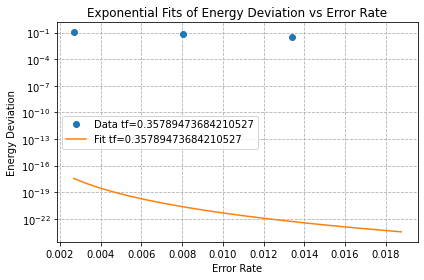

R² = -1.7035-0.0000j
[0.05617185+1.16482436e-16j 0.13935883-2.57938543e-17j
 0.20691919-2.08929132e-17j 0.26177433-1.72724694e-17j]
(4,)


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


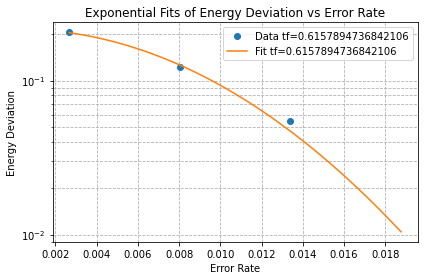

R² = 0.9921+0.0000j
[0.07864621-5.34838354e-17j 0.18572606+3.37050573e-17j
 0.26532416+8.26579253e-18j 0.32450619+1.09043746e-17j]
(4,)


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


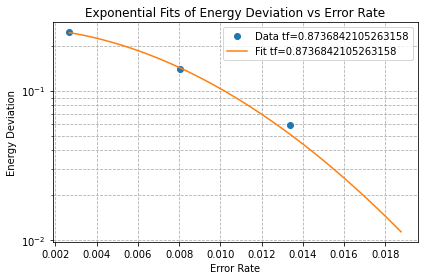

R² = 0.9937-0.0000j
[0.10706529+2.80123088e-17j 0.24105878-5.09311332e-18j
 0.32866395-2.73105082e-18j 0.38600067+2.23781904e-17j]
(4,)


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


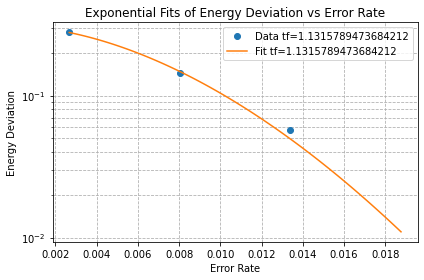

R² = 0.9957-0.0000j
[0.12561191+1.88212124e-17j 0.27280592+1.41128342e-17j
 0.36104845+1.85922303e-17j 0.41406794-1.41247185e-17j]
(4,)


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


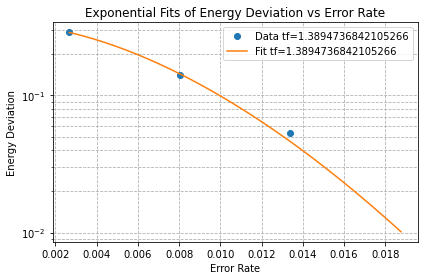

R² = 0.9967+0.0000j
[0.15087041+6.92673406e-18j 0.31176283+5.29386420e-17j
 0.39673599+1.51168711e-17j 0.44185461-3.89375584e-18j]
(4,)


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


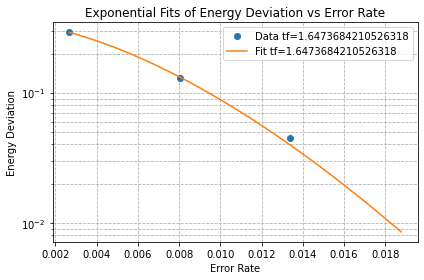

R² = 0.9978+0.0000j
[0.1738689 -1.92289156e-17j 0.3429681 -3.74006047e-17j
 0.42185595-8.68750361e-20j 0.45903945-6.45846110e-18j]
(4,)


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


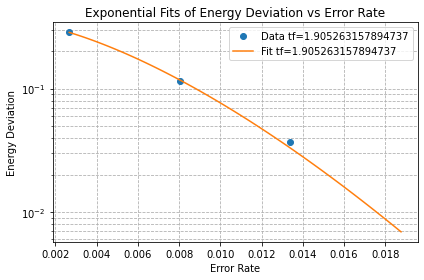

R² = 0.9986+0.0000j
[0.1886957 +1.69251981e-17j 0.36082258-5.48461875e-17j
 0.43469749-5.20418970e-18j 0.46690387+1.38619627e-17j]
(4,)


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


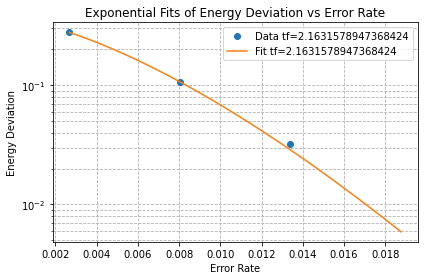

R² = 0.9990-0.0000j
[0.20875814-5.08706396e-17j 0.38255429+2.19308900e-17j
 0.44872941+5.06162554e-18j 0.47461181+9.44452421e-18j]
(4,)


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


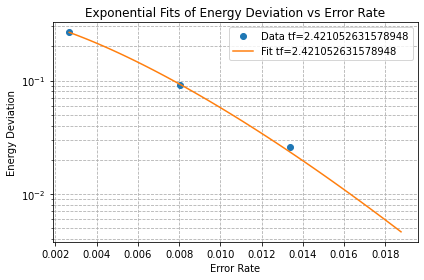

R² = 0.9993-0.0000j
[0.22161703-4.53627550e-17j 0.39495089-3.48416442e-17j
 0.45590573-2.34950943e-17j 0.47816054+6.43118045e-18j]
(4,)


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


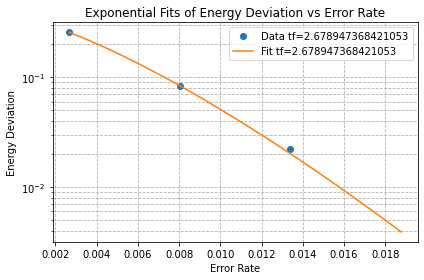

R² = 0.9995-0.0000j
[0.23879638-1.25264027e-17j 0.40998893-4.35686582e-18j
 0.46371694-4.79823915e-18j 0.48160871-4.74966285e-19j]
(4,)


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


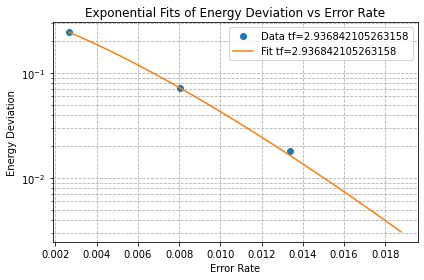

R² = 0.9997-0.0000j
[0.25001477+4.68350068e-17j 0.41863115+6.26158437e-18j
 0.46774726+1.16983706e-18j 0.48322559+3.84222014e-18j]
(4,)


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


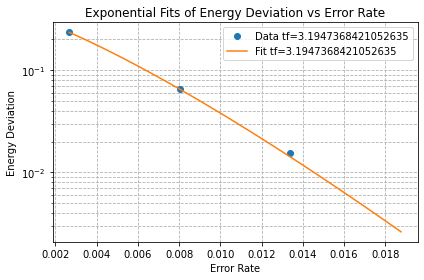

R² = 0.9997-0.0000j
[0.26485231+2.17216619e-17j 0.42905667+1.79572615e-17j
 0.47209838+1.74215824e-19j 0.48476652+7.09563443e-18j]
(4,)


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


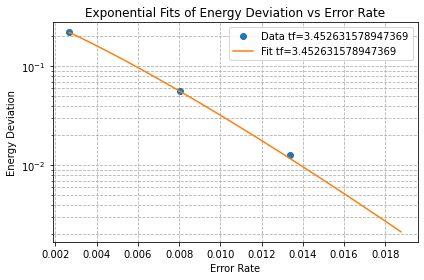

R² = 0.9998-0.0000j
[0.27848837-7.89058485e-17j 0.4374582 -8.18797701e-20j
 0.47517581-1.10195408e-19j 0.48572218-1.67508723e-18j]
(4,)


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


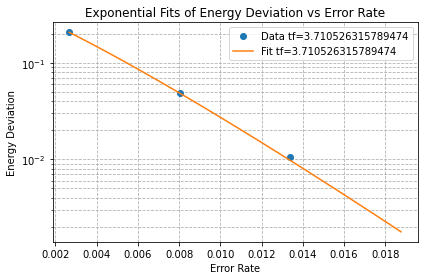

R² = 0.9999+0.0000j
[0.28735837-5.91065590e-17j 0.44230658+1.14456686e-17j
 0.4767937 +9.34636302e-18j 0.48620055-6.29826980e-18j]
(4,)


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


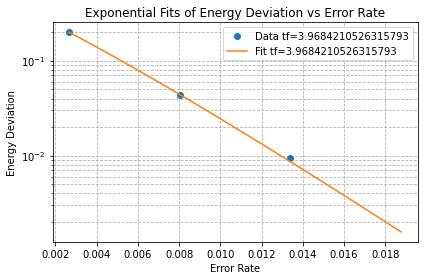

R² = 0.9999+0.0000j
[0.29912322-1.82091980e-17j 0.44813478+1.03027628e-17j
 0.47850815-6.49654924e-18j 0.48662514-6.38375345e-18j]
(4,)


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


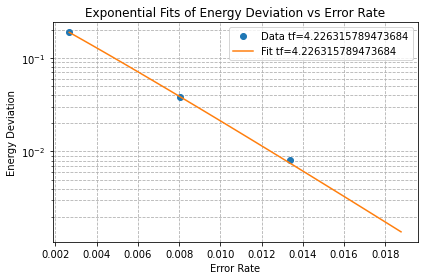

R² = 0.9999-0.0000j
[0.30674841+1.77289136e-17j 0.45151545+3.38768632e-20j
 0.47943077+7.88925464e-18j 0.48685897+6.08355200e-18j]
(4,)


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


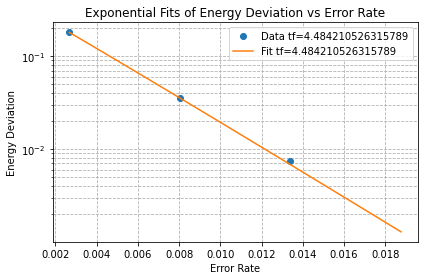

R² = 0.9999+0.0000j
[0.31697164+5.55285565e-17j 0.45556693-7.18095067e-18j
 0.48038546-5.56028565e-18j 0.48704508+5.65560784e-18j]
(4,)


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


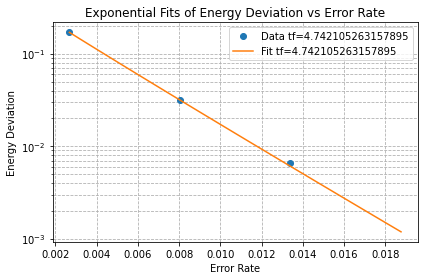

R² = 0.9999-0.0000j
[0.32629983+1.43483493e-17j 0.45882748+6.09561487e-18j
 0.48105993+3.45041963e-18j 0.48715887+4.23353956e-18j]
(4,)


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


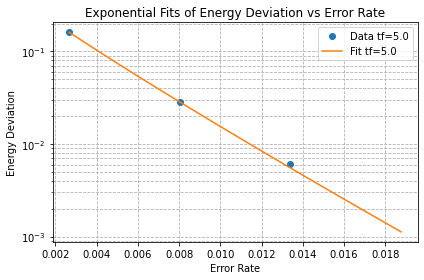

R² = 0.9999-0.0000j
a_fit values for each tf:
[100.23815976   0.21681366   0.26398185   0.30875482   0.32695986
   0.3431448    0.35164657   0.35471702   0.35738724   0.35843799
   0.36045071   0.3616721    0.3653058    0.3708754    0.37569239
   0.38607609   0.39483646   0.41112155   0.43126335]


In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Example setup — replace with your actual data
errors = np.array([1, 3, 5, 7]) * 2.68e-3  # [num_noise_levels]

print(n_errors_vs_tf.shape)
# Define exponential decay model
def exp_decay(x, a, b,c):
    return a * np.exp(-b * x**c) 

# To store fitted parameters
fit_params = []


print(n_errors_vs_tf.shape)

print(n_errors_vs_tf[3])
shift_values=[]
for i, n_values in enumerate(n_errors_vs_tf[1:]):
    print(n_values)
    n_deviation = n_values[-1]-n_values
    print(n_deviation.shape)
    try:
        params, _ = curve_fit(exp_decay, errors, n_deviation, p0=(1, 1,0))
        a_fit, b_fit, c_fit = params
        fit_params.append(params)

        # Plot
        x_fit = np.linspace(min(errors), max(errors), 100)
        y_fit = exp_decay(x_fit, a_fit, b_fit, c_fit)
        plt.plot(errors, n_deviation, 'o', label=f'Data tf={tfs[i+1]}')
        plt.plot(x_fit, y_fit, '-', label=f'Fit tf={tfs[i+1]}')
        # Final plot settings
        plt.semilogy()
        plt.xlabel("Error Rate")
        plt.ylabel("Energy Deviation")
        plt.legend()
        plt.grid(True, which='both', ls='--')
        plt.title("Exponential Fits of Energy Deviation vs Error Rate")
        plt.tight_layout()
        plt.show()
    
    except RuntimeError:
        print(f"Fit failed for tf index {i}")
        fit_params.append((np.nan, np.nan, np.nan))
    shift_values.append(a_fit)
    


    # Predicted values
    y_pred = exp_decay(errors, a_fit, b_fit,c_fit)

    # Actual values
    y_true = n_deviation

    # Compute R^2
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    print(f"R² = {r_squared:.4f}")
    


# Convert parameters to NumPy array for further use
fit_params = np.array(fit_params)

# Optional: Print just the a_fit parameters
print("a_fit values for each tf:")
print(fit_params[:, 0])

In [66]:
n_zne_vs_tf=[]
tfs_zne=[]
for i in range(1,tfs.shape[0]):
    tfs_zne.append(tfs[i])
    print(n_errors_vs_tf[i])
    print('estimation=',n_errors_vs_tf[i,-1]-shift_values[i-1],'exact=',n_vs_tf[i],'without zne=',n_errors_vs_tf[i,-1],'tf=',tfs[i],'\n')
    n_zne_vs_tf.append(n_errors_vs_tf[i,-1]-shift_values[i-1])
    

[0.02666606+1.03244173e-17j 0.06406475+3.93956505e-17j
 0.0985808 -2.36499190e-18j 0.13042622+3.10789639e-17j]
estimation= (-100.10773353694563+3.1078963882807217e-17j) exact= (0.0053281154876616554+0j) without zne= (0.1304262210652507+3.1078963882807217e-17j) tf= 0.35789473684210527 

[0.05617185+1.16482436e-16j 0.13935883-2.57938543e-17j
 0.20691919-2.08929132e-17j 0.26177433-1.72724694e-17j]
estimation= (0.0449606661685058-1.7272469401895298e-17j) exact= (0.0019648551425650584+0j) without zne= (0.2617743291258845-1.7272469401895298e-17j) tf= 0.6157894736842106 

[0.07864621-5.34838354e-17j 0.18572606+3.37050573e-17j
 0.26532416+8.26579253e-18j 0.32450619+1.09043746e-17j]
estimation= (0.06052433524570072+1.0904374599971236e-17j) exact= (0.0031394169432299446+0j) without zne= (0.3245061870808268+1.0904374599971236e-17j) tf= 0.8736842105263158 

[0.10706529+2.80123088e-17j 0.24105878-5.09311332e-18j
 0.32866395-2.73105082e-18j 0.38600067+2.23781904e-17j]
estimation= (0.0772458528515214

/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


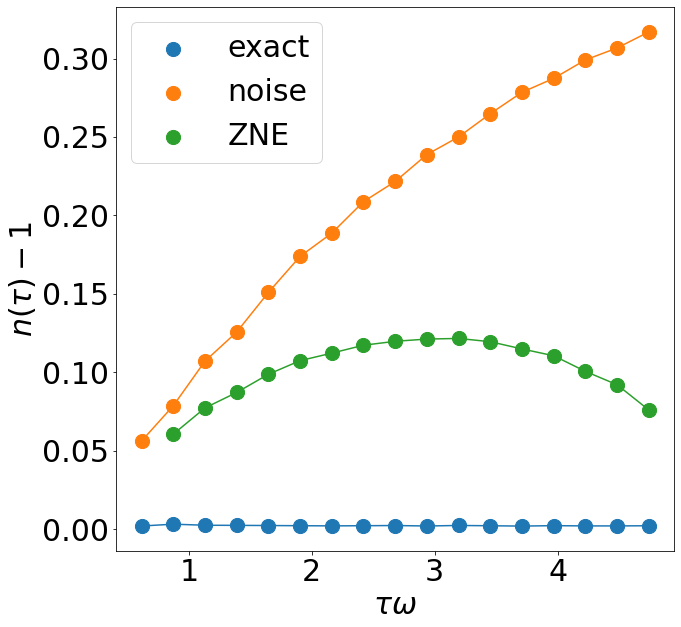

In [68]:
plt.figure(figsize=(10,10))
plt.plot(tfs[2:-1],n_vs_tf[2:-1])
plt.scatter(tfs[2:-1],n_vs_tf[2:-1],s=200,label='exact')
plt.plot(tfs[2:-1],n_errors_vs_tf[2:-1,0])
plt.scatter(tfs[2:-1],n_errors_vs_tf[2:-1,0],s=200,label='noise')
plt.plot(tfs_zne[2:-1],n_zne_vs_tf[2:-1])
plt.scatter(tfs_zne[2:-1],n_zne_vs_tf[2:-1],s=200,label='ZNE')
plt.tick_params(which='major',labelsize=30)
plt.legend(fontsize=30)
plt.xlabel(r'$\tau \omega$',fontsize=30)
plt.ylabel(r'$n(\tau)-1$',fontsize=30)
plt.show()

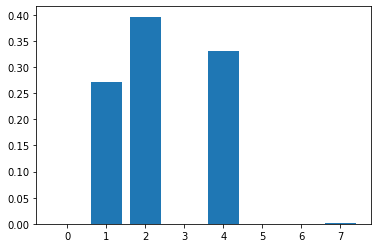

(8,)
(8,)
(8,)


In [30]:
import matplotlib.pyplot as plt



prob=final_state.probabilities()

plt.bar(np.arange(prob.shape[0]),prob)
plt.show()

# convert into the single particle state
single_particle_vector=np.zeros(2**n_qubits,dtype=np.complex128)

for a in range(n_qubits):
    a_mb=2**(a)
    print(final_state.data.shape)
    single_particle_vector[a_mb]=final_state.data[a_mb]
single_particle_vector=single_particle_vector/np.linalg.norm(single_particle_vector) 
final_state_clean_single_particle=Statevector(single_particle_vector)

In [32]:
print(np.linalg.norm(single_particle_vector))
print(np.linalg.norm(final_state.data))
print(final_state.expectation_value(hamiltonian_q))

1.0
0.9999999999999992
(-31.291812300918675+0j)


In [21]:
from qiskit import transpile

# Define your basis gates
custom_basis_gates = ['cz', 'id', 'rz', 'sx', 'x']

# Transpile your circuit using those gates
transpiled_initial_state = transpile(
    initial_state,  # your circuit here
    basis_gates=custom_basis_gates,
    optimization_level=3  # or 0–3 depending on your needs
)

In [ ]:
transpiled_initial_state.draw()

In [166]:
print(
    f"""
Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: {transpiled_initial_state.depth()}
             Gate count: {len(transpiled_initial_state)}
    Nonlocal gate count: {transpiled_initial_state.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in transpiled_initial_state.count_ops().items()])}

"""
)


Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: 427
             Gate count: 709
    Nonlocal gate count: 108
         Gate breakdown: RZ: 272, SX: 264, CZ: 108, X: 65




#### NOISE MODELS

#### Ionq simulator

In [ ]:
import os
from qiskit_ionq import IonQProvider


provider = IonQProvider(token="iNarGLptgimgFldYpwMY5x8mTxRZE1C2")
print(provider.backends())

simulator_backend = provider.get_backend("simulator")
simulator_backend.set_options(noise_model="aria-1")

# Create a basic Bell State circuit:


result = simulator_backend.run(initial_state).result()

# Print the counts


#### Simulation quantum Annealing

In [43]:

#final_state=Statevector(circuit_opt)
time_steps=20
tf=2
time=np.linspace(0,tf,time_steps)
dt=tf/time_steps
#b=1.5
#h=1-(1+b)*(time/tf)+b*(time/tf)**2
h=1-time/tf
initial_state=QuantumCircuit(hamiltonian_q.num_qubits)
initial_state.x([0])

for n,t in enumerate(time):
    hamiltonian_t=(h[n])*hamiltonian_driver+(1-h[n])*hamiltonian_q
    exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
    initial_state.append(exp_H_t,range(hamiltonian_q.num_qubits))
    
# Define your basis gates
basis_gates_kingston = ['cz', 'id', 'rz', 'sx', 'x']
basis_gates_eagles= ['ecr', 'id', 'rz', 'sx', 'x']
basis_gates_acheen=['cz', 'id', 'rz', 'rz', 'rzz', 'sx', 'x']
transpiled_initial_state=transpile(initial_state, optimization_level=3,basis_gates=basis_gates_acheen)
final_state=Statevector(initial_state)

#### IBM ibm_aachen

In [46]:
t1 = 225.54 * 1e3  # 225.54 us to ns
t2 = 183.22 * 1e3  # 183.22 us to ns

gate_time_1q = 50   # estimate for single-qubit gates
gate_time_2q = 350  # estimate for two-qubit gates (CZ, RZZ)

from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors import thermal_relaxation_error, depolarizing_error, ReadoutError

thermal_1q = thermal_relaxation_error(t1, t2, gate_time_1q)
thermal_2q = thermal_relaxation_error(t1, t2, gate_time_2q)

# Compose with depolarizing error to match median error
sx_error = depolarizing_error(1.840e-4, 1).compose(thermal_1q)
cz_error = depolarizing_error(1.885e-3, 2).compose(thermal_2q)

readout_err = ReadoutError([[1 - 6.836e-3, 6.836e-3], [6.836e-3, 1 - 6.836e-3]])

noise_model = NoiseModel()

for gate in ['sx', 'rx', 'x', 'id']:
    noise_model.add_all_qubit_quantum_error(sx_error, gate)

# CZ and RZZ are both 2-qubit gates; you can add noise to both or just CZ
noise_model.add_all_qubit_quantum_error(cz_error, 'cz')
noise_model.add_all_qubit_quantum_error(cz_error, 'rzz')


#### IBM Eagle noise

In [45]:
t1 = 230.95 * 1e3  # us to ns
t2 = 129.47 * 1e3  # us to ns

gate_time_1q = 50    # ns, estimate for SX, RZ, X gates
gate_time_2q = 300   # ns, estimate for ECR gate


from qiskit_aer.noise.errors import thermal_relaxation_error

thermal_1q = thermal_relaxation_error(t1, t2, gate_time_1q)
thermal_2q = thermal_relaxation_error(t1, t2, gate_time_2q)

from qiskit_aer.noise.errors import depolarizing_error

# SX is single-qubit
sx_error = depolarizing_error(2.476e-4, 1).compose(thermal_1q)

# ECR is two-qubit gate
ecr_error = depolarizing_error(7.294e-3, 2).compose(thermal_2q)

from qiskit_aer.noise import NoiseModel

noise_model = NoiseModel()

# Add errors to basis gates
for gate in ['sx', 'rz', 'x']:
    noise_model.add_all_qubit_quantum_error(sx_error, gate)

noise_model.add_all_qubit_quantum_error(ecr_error, 'ecr')

##### IBM ibm_kingston parameters

In [ ]:
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError

# Median calibration data (converted to nanoseconds)
cz_error_rate = 1.911e-3
sx_error_rate = 2.023e-4
readout_error_rate = 8.301e-3
t1 = 284.35e3  # µs -> ns
t2 = 147.16e3  # µs -> ns
gate_time_1q = 35   # ns, typical for SX/RZ/X
gate_time_2q = 200  # ns, rough estimate for CZ

# Create a noise model
noise_model = NoiseModel()

# Add gate errors
cz_depol = depolarizing_error(cz_error_rate, 2)
sx_depol = depolarizing_error(sx_error_rate, 1)
rz_depol = depolarizing_error(1e-5, 1)
x_depol = depolarizing_error(1e-4, 1)

# Add depolarizing errors
noise_model.add_all_qubit_quantum_error(cz_depol, 'cz')
noise_model.add_all_qubit_quantum_error(sx_depol, 'sx')
noise_model.add_all_qubit_quantum_error(rz_depol, 'rz')
noise_model.add_all_qubit_quantum_error(x_depol, 'x')

# Add thermal relaxation errors
thermal_1q = thermal_relaxation_error(t1, t2, gate_time_1q)
thermal_2q = thermal_relaxation_error(t1, t2, gate_time_2q)

for gate in ['sx', 'rz', 'x']:
    noise_model.add_all_qubit_quantum_error(thermal_1q, gate)
#trnoise_model.add_all_qubit_quantum_error(thermal_2q, 'cz')

# Add readout error
# ro_error = ReadoutError([
#     [1 - readout_error_rate, readout_error_rate],
#     [readout_error_rate, 1 - readout_error_rate]
# ])
# noise_model.add_all_qubit_readout_error(ro_error)

# You now have a realistic noise model for a Heron r2-class device

##### Kind of IonQ

In [133]:
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.circuit.library.standard_gates import IGate, XGate, YGate, ZGate, HGate, CXGate

# System parameters (choose Aria 1 here)
r1q = 0.00004     # 1-qubit error rate
r2q = 0.00139     # 2-qubit error rate best performance ever

# Create noise model
noise_model = NoiseModel()

# Define one-qubit depolarizing error
one_qubit_error = depolarizing_error(r1q, 1)

# Define two-qubit depolarizing error
two_qubit_error = depolarizing_error(r2q, 2)

# # Add the one-qubit error to all single-qubit gates


# # Add the two-qubit error to all two-qubit gates (like CX)

    
    
# Assume 0.001 single-qubit error, 0.01 two-qubit error
one_q_error = depolarizing_error(r1q, 1)
two_q_error = depolarizing_error(r2q, 2)

# Add to your favorite gates
#noise_model.add_all_qubit_quantum_error(one_q_error, ['u3'])
#noise_model.add_all_qubit_quantum_error(two_q_error, ['cx'])
for gate in ['cx', 'cz', 'swap']:
    noise_model.add_all_qubit_quantum_error(two_qubit_error, gate)
for gate in ['id', 'x', 'y', 'z', 'h', 's', 't', 'rx', 'ry', 'rz', 'u1', 'u2', 'u3']:
    noise_model.add_all_qubit_quantum_error(one_qubit_error, gate)

#### Simulate with noise

In [47]:
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import Fake5QV1  # or another IBM backend
from qiskit import transpile
from qiskit.quantum_info import DensityMatrix

sim = AerSimulator(noise_model=noise_model)
transpiled_initial_state.save_density_matrix()
# Transpile and run
tqc = transpile(transpiled_initial_state, sim,optimization_level=3)
result = sim.run(tqc).result()



In [ ]:
tqc.draw()

In [26]:
print(
    f"""
Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: {tqc.depth()}
             Gate count: {len(tqc)}
    Nonlocal gate count: {tqc.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in tqc.count_ops().items()])}

"""
)


Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: 390
             Gate count: 624
    Nonlocal gate count: 108
         Gate breakdown: RZ: 228, SX: 172, CZ: 108, X: 65, RX: 50, SAVE_DENSITY_MATRIX: 1




In [49]:
# Get the output state vector or density matrix
from qiskit.quantum_info import DensityMatrix,state_fidelity
dm = result.data(0)['density_matrix']
print(dm.shape)
density_matrix_final_state=DensityMatrix(dm)
print(density_matrix_final_state.expectation_value(hamiltonian_q))

(8, 8)
(-9.697298986072628-1.0604586013184745e-16j)


/tmp/ipykernel_3970436/3824665734.py:4: DeprecationWarning: The return type of saved density matrices has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.DensityMatrix` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  print(dm.shape)


/tmp/ipykernel_3970436/3999158546.py:4: DeprecationWarning: The return type of saved density matrices has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.DensityMatrix` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  sp_dm[2**(i-1),2**(j-1)]=dm[2**(i-1),2**(j-1)]


<BarContainer object of 8 artists>

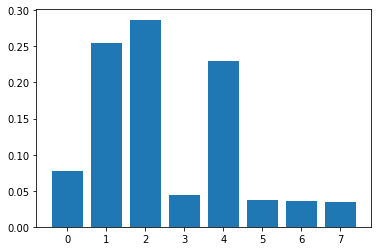

In [50]:
sp_dm=np.zeros((2**n_qubits,2**n_qubits),dtype=np.complex128)
for i in range(1,n_qubits+1):
    for j in range(1,n_qubits+1):
        sp_dm[2**(i-1),2**(j-1)]=dm[2**(i-1),2**(j-1)]

sp_dm=sp_dm/np.trace(sp_dm)
density_matrix_final_state_single_particle=DensityMatrix(sp_dm)

plt.bar(np.arange(2**n_qubits),density_matrix_final_state.probabilities())

(-2.2363417151214344-3.555536307531051e-32j) 0.6925098050507775


<BarContainer object of 8 artists>

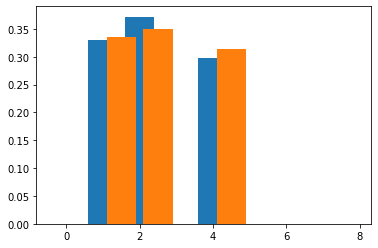

In [51]:
print(density_matrix_final_state_single_particle.expectation_value(hamiltonian_q)+7.8,state_fidelity(density_matrix_final_state,final_state_clean_single_particle))

plt.bar(np.arange(2**n_qubits),density_matrix_final_state_single_particle.probabilities())
plt.bar(np.arange(2**n_qubits)+0.5,final_state_clean_single_particle.probabilities())


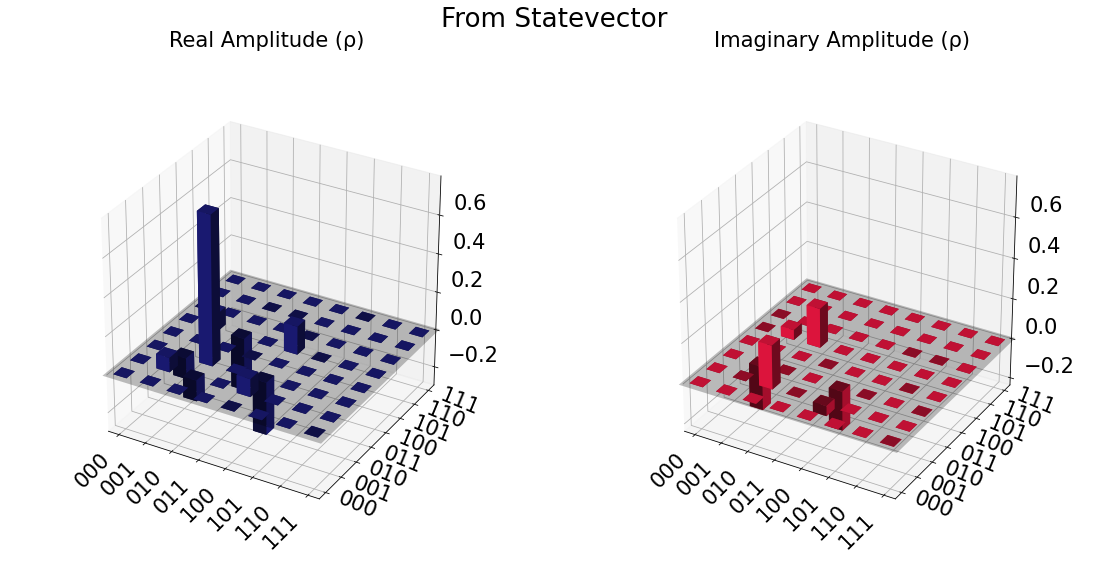

In [174]:
from qiskit.visualization import plot_bloch_vector
from qiskit.quantum_info import Statevector, DensityMatrix

from qiskit.visualization import plot_state_city
# Example state
sv = final_state_clean_single_particle              # |+> = (|0> + |1>)/sqrt(2)
dm = density_matrix_final_state_single_particle       # Completely mixed state


# Convert statevector to density matrix
dm_from_sv = DensityMatrix(sv)

# Plot side-by-side city plots (2D bar graphs)
# Plot first density matrix
plot_state_city(dm_from_sv, title="From Statevector", color=['midnightblue', 'crimson'])



# Plot second (possibly noisy) density matrix


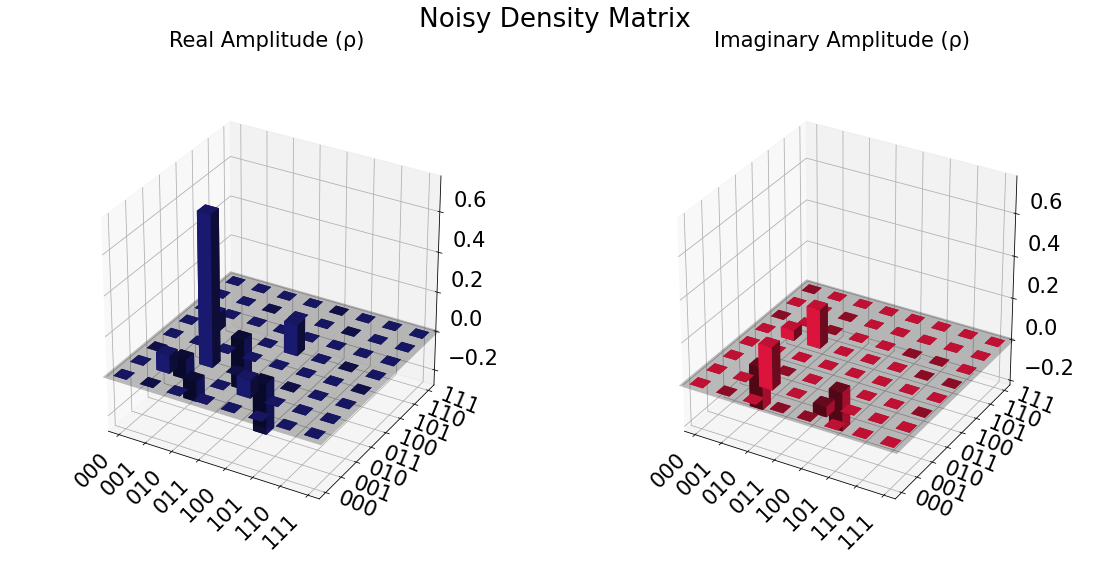

In [175]:
plot_state_city(density_matrix_final_state_single_particle, title="Noisy Density Matrix", color=['midnightblue', 'crimson'])


#### What about quantum optimal control with the time schedule?

In [53]:
class OptimalControlQiskitClean:
    
    def __init__(self,tf,time_steps,n_parameters,hamiltonian_q,hamiltonian_driver):
        
        self.omegas=2*np.pi*np.arange(1,n_parameters+1)*(1+np.random.uniform(-0.5,0.5,n_parameters))/tf
        self.time=np.linspace(0,tf,time_steps)
        self.tf=tf
        self.time_steps=time_steps
        self.parameters=np.zeros(4*n_parameters)
        self.final_psi=None
        self.hamiltonian_q=hamiltonian_q
        self.hamiltonian_driver=hamiltonian_driver
    def energy_quantum_annealing(self,parameters:np.ndarray):
        
        dim=parameters.shape[0]//4
        matrix_driver=(parameters[:dim,None]*np.sin(self.time[None,:]*self.omegas[:,None])+parameters[dim:2*dim,None]*np.cos(self.time[None,:]*self.omegas[:,None]))
        matrix_target=(parameters[2*dim:3*dim,None]*np.sin(self.time[None,:]*self.omegas[:,None])+parameters[3*dim:4*dim,None]*np.cos(self.time[None,:]*self.omegas[:,None]))

        h_driver=(1-self.time/self.tf)*(1+np.average(matrix_driver,axis=0))
        h_target=(self.time/self.tf)*(1+np.average(matrix_target,axis=0))
        
        initial_state=QuantumCircuit(hamiltonian_q.num_qubits)
        initial_state.x([0])
        for n,t in enumerate(time):
            hamiltonian_t=(h_driver[n])*self.hamiltonian_driver+(h_target[n])*self.hamiltonian_q
            exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
            initial_state.append(exp_H_t,range(hamiltonian_t.num_qubits))
            
        
            
        # Define your basis gates
        #basis_gates_kingston = ['cz', 'id', 'rz', 'sx', 'x']
        #basis_gates_eagles= ['ecr', 'id', 'rz', 'sx', 'x']
        basis_gates_acheen=['cz', 'id', 'rz', 'rz', 'rzz', 'sx', 'x']
        transpiled_initial_state=transpile(initial_state, optimization_level=3,basis_gates=basis_gates_acheen)
        final_state=Statevector(initial_state)
        
                # convert into the single particle state
        single_particle_vector=np.zeros(2**n_qubits,dtype=np.complex128)

        for a in range(n_qubits):
            a_mb=2**(a)
            print(final_state.data.shape)
            single_particle_vector[a_mb]=final_state.data[a_mb]
        single_particle_vector=single_particle_vector/np.linalg.norm(single_particle_vector) 
        final_state_clean_single_particle=Statevector(single_particle_vector)
        self.final_psi=final_state_clean_single_particle
        print(final_state_clean_single_particle.expectation_value(hamiltonian_q).real)
        return final_state_clean_single_particle.expectation_value(hamiltonian_q).real
        
        

In [56]:
class OptimalControlQiskitNoise:
    
    def __init__(self,tf,time_steps,n_parameters,hamiltonian_q,hamiltonian_driver,noise_model):
        
        self.omegas=2*np.pi*np.arange(1,n_parameters+1)*(1+np.random.uniform(-0.5,0.5,n_parameters))/tf
        self.time=np.linspace(0,tf,time_steps)
        self.tf=tf
        self.time_steps=time_steps
        self.parameters=np.zeros(4*n_parameters)
        self.final_psi=None
        self.hamiltonian_q=hamiltonian_q
        self.hamiltonian_driver=hamiltonian_driver
        self.noise_model=noise_model
    def energy_quantum_annealing(self,parameters:np.ndarray):
        
        dim=parameters.shape[0]//4
        matrix_driver=(parameters[:dim,None]*np.sin(self.time[None,:]*self.omegas[:,None])+parameters[dim:2*dim,None]*np.cos(self.time[None,:]*self.omegas[:,None]))
        matrix_target=(parameters[2*dim:3*dim,None]*np.sin(self.time[None,:]*self.omegas[:,None])+parameters[3*dim:4*dim,None]*np.cos(self.time[None,:]*self.omegas[:,None]))

        self.h_driver=(1-self.time/self.tf)*(1+np.average(matrix_driver,axis=0))
        self.h_target=(self.time/self.tf)*(1+np.average(matrix_target,axis=0))
        
        initial_state=QuantumCircuit(hamiltonian_q.num_qubits)
        initial_state.x([0])
        for n,t in enumerate(self.time):
            hamiltonian_t=(self.h_driver[n])*self.hamiltonian_driver+(self.h_target[n])*self.hamiltonian_q
            exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
            initial_state.append(exp_H_t,range(hamiltonian_t.num_qubits))
        
        # Define your basis gates
        #basis_gates_kingston = ['cz', 'id', 'rz', 'sx', 'x']
        #basis_gates_eagles= ['ecr', 'id', 'rz', 'sx', 'x']
        basis_gates_acheen=['cz', 'id', 'rz', 'rz', 'rzz', 'sx', 'x']
        transpiled_initial_state=transpile(initial_state, optimization_level=3,basis_gates=basis_gates_acheen)
        
        sim = AerSimulator(noise_model=self.noise_model)
        transpiled_initial_state.save_density_matrix()
        # Transpile and run
        tqc = transpile(transpiled_initial_state, sim,optimization_level=3)
        result = sim.run(tqc).result()
        
        dm = result.data(0)['density_matrix']
        
        sp_dm=np.zeros((2**n_qubits,2**n_qubits),dtype=np.complex128)
        for i in range(1,n_qubits+1):
            for j in range(1,n_qubits+1):
                sp_dm[2**(i-1),2**(j-1)]=np.asarray(dm)[2**(i-1),2**(j-1)]

        sp_dm=sp_dm/np.trace(sp_dm)
        density_matrix_final_state_single_particle=DensityMatrix(sp_dm)
        self.density_matrix_single_particle=density_matrix_final_state_single_particle
        print(density_matrix_final_state_single_particle.expectation_value(hamiltonian_q).real)
        self.parameters=parameters
        return density_matrix_final_state_single_particle.expectation_value(hamiltonian_q).real


In [57]:
from scipy.optimize import minimize

OCQ=OptimalControlQiskitNoise(tf=2,time_steps=20,n_parameters=10,hamiltonian_q=hamiltonian_q,hamiltonian_driver=hamiltonian_driver,noise_model=noise_model)

res = minimize(
                    OCQ.energy_quantum_annealing,
                    OCQ.parameters,
                    method='L-BFGS-B',
                    tol=10**-3,
                    options=None,
                    
                )

OCQ.parameters = res.x
energy = OCQ.energy_quantum_annealing(OCQ.parameters)
print(energy)
print(OCQ.parameters)


-10.03634171512143
-10.034191381818019
-10.034666983905876
-10.034441619496691
-10.033681515269558
-10.036341715105895
-10.033895148598972
-10.037616381884284
-10.033704669717858
-10.03604515643687
-10.033518578312774
-10.035941227510499
-10.034440914286034
-10.033298432730454
-10.034440895201666
-10.036045766411911
-10.034667042666078
-10.037616381883936
-10.034439819141486
-10.03518702280973
-10.034667012701188
-10.034441236536434
-10.036270990310296
-10.036341715188303
-10.034440950512229
-10.034435757717027
-10.036341715135078
-10.036040588851431
-10.035941227997926
-10.036270994406141
-10.034666987873306
-10.037616381844986
-10.037616381787014
-10.035941228165306
-10.034441158260679
-10.034665687994764
-10.036045184325824
-10.036044568476504
-10.037616381888405
-10.037616381884877
-10.036045296602033
-10.024734356247944
-10.026341526445286
-10.024509575090237
-10.02371646721075
-10.024734566217862
-10.024734388277043
-10.025929826882612
-10.027675677935262
-10.027675677935033
-10.

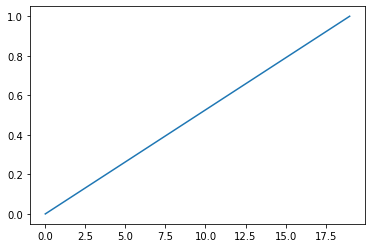

In [42]:
plt.plot(OCQ.h_target)
plt.show()

#### Run on a IBM machine

In [9]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter,QDrift
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import transpile
from qiskit.quantum_info import Statevector

#final_state=Statevector(circuit_opt)
time_steps=100
tf=10
time=np.linspace(0,tf,time_steps)
dt=tf/time_steps
#b=0.8
#h=1-(1+b)*(time/tf)+b*(time/tf)**2
h=1-time/tf
circuit_time_evolution=QuantumCircuit(hamiltonian_q.num_qubits,hamiltonian_q.num_qubits)
circuit_time_evolution.x([0]) # initial state

energies_qiskit=np.zeros((time_steps))


for n,t in enumerate(time):
    hamiltonian_t=((h[n])*hamiltonian_driver+(1-h[n])*hamiltonian_q)
    exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
    circuit_time_evolution.append(exp_H_t,range(hamiltonian_q.num_qubits))
    single_particle_vector=np.zeros(2**n_qubits,dtype=np.complex128)
    psi_for_fidelity=np.zeros(n_qubits,dtype=np.complex128)
    # for a in range(n_qubits):
    #     a_mb=2**(a)
    #     final_state=Statevector(circuit_time_evolution).data
    #     single_particle_vector[a_mb]=final_state[a_mb]
    #     psi_for_fidelity[a]=final_state[a_mb]
    # energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)
print(Statevector(circuit_time_evolution).expectation_value(hamiltonian_q))
transpiled_circuit_time_evolution=transpile(circuit_time_evolution.decompose(), optimization_level=3,basis_gates=['cx','s','h','rz','x'])

(-31.334163248207602+0j)


In [12]:
from qiskit_ibm_provider import IBMProvider
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke,FakeMarrakesh,FakeValenciaV2,FakeTorino
from qiskit_aer import StatevectorSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_experiments.test import PulseBackend
# Replace with your actual API token
# service = IBMProvider(token='91830ee51d4a39179a63363dd51d2b588653b869a4cab814c29deb5ac3ded710d02c63902e330e53bbfb36994a605f76f6822b3e608a78b38cc8927e023b0ea9')
# backends = service.backends()
# for backend in backends:
#     print(backend.name)
    

    
# # Load the service
# #service = QiskitRuntimeService(token='91830ee51d4a39179a63363dd51d2b588653b869a4cab814c29deb5ac3ded710d02c63902e330e53bbfb36994a605f76f6822b3e608a78b38cc8927e023b0ea9')
backend = FakeTorino()
# backend = service.get_backend("ibm_brisbane")

# service = QiskitRuntimeService()
# backend = service.least_busy(
#     operational=True, simulator=False, min_num_qubits=127
# )

# print(backend)
#backend=StatevectorSimulator()
 
estimator = Estimator(mode=backend)
options = estimator.options
# Turn on gate twirling.
options.twirling.enable_gates = True
options.twirling.num_randomizations = 60
options.twirling.shots_per_randomization = 100
options.resilience.pec_mitigation = True
options.resilience.pec_mitigation = True
# #options.resilience.pec.max_overhead = 300
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XpXm"

# options.resilience.zne_mitigation = True
# options.resilience.zne.noise_factors = (1, 2, 3,4,5,6)
# options.resilience.zne.extrapolator = "exponential"
# estimator.options.resilience.zne.amplifier = "pea"


pm = generate_preset_pass_manager(backend=backend, optimization_level=3)



transpiled_qc=pm.run(transpiled_circuit_time_evolution)
layout = transpiled_qc.layout

h_squared=(hamiltonian_q @ hamiltonian_q).simplify()
observables = [
    hamiltonian_q
]
observables = [
    [observable.apply_layout(layout) for observable in observable_set]
    for observable_set in observables
]


estimator_pub = (transpiled_qc ,observables)

transpiled_qc.draw()

#print(f">>> gate twirling is turned on: {sampler.options.twirling.enable_gates}")


job = estimator.run([estimator_pub])
result = job.result()

/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:269: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}, 'resilience': {'pec_mitigation': True}, 'twirling': {'enable_gates': True, 'num_randomizations': 60, 'shots_per_randomization': 100}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [13]:

import matplotlib.pyplot as plt 
from qiskit.visualization import plot_histogram
%matplotlib inline

print(np.sum(result[0].data.evs))

-37.79197246071122
